In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import json
import tkp.db
import tkp.config
import logging
import csv
import time
import sys

import itertools
import pylab
import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
import datetime
import os
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.wcs import WCS


import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import interpolate, signal


import pymc3 as pm
from scipy.stats import norm

from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

# plt.rcParams['font.size']= 16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skewnorm(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)


def delta(shape):
    return (shape/pm.math.sqrt(1.0+shape**2.))


def muz(shape):
    return pm.math.sqrt(2./np.pi)*delta(shape) 

def skewness(shape):
    return (4.- np.pi)/2. * ((delta(shape)*pm.math.sqrt(2./np.pi))**3.)/(1.0-(2.0*delta(shape)**2.)/np.pi)**(3./2.)

def sigmaz(shape):
    return np.sqrt(1.-muz(shape)**2.)


def skew_mode(shape):
    return pm.math.sqrt(2.0/np.pi)*delta(shape) - \
        skewness(shape) * pm.math.sqrt(1.0 - (pm.math.sqrt(2.0/np.pi)*delta(shape))**2 )/2.0 - \
        (pm.math.sgn(shape) / 2.0) *( pm.math.exp (-(2.0*np.pi)/pm.math.abs_(shape)))


def sk_mode(loc,scale,shape):
    return loc + skew_mode(shape) * scale

def fit_lightcurve(y, draws=500,chains=4, njobs=4):
    with pm.Model() as model:

        (mu, sigma) = norm.fit(y)

        loc = pm.Normal("loc",mu, 20)
        scale = pm.HalfNormal("scale", sigma)
        skew = pm.Normal("skew", 0, 5)
        mode = pm.Deterministic("mode",sk_mode(loc,scale,skew))
        _y = pm.SkewNormal("y_dist",mu=loc, sd=scale,alpha=skew, observed=y)
        trace = pm.sample(draws=draws, chains=chains, njobs=njobs)
    mode = pm.summary(trace)[pm.summary(trace).index == "mode"]["mean"].values[0]
    mode_err = pm.summary(trace)[pm.summary(trace).index == "mode"]["sd"].values[0]
        
    return mode, mode_err

In [4]:
def dump_trans(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    # find all the new, candidate transient, sources detected by the pipeline
    transients_query = """
    SELECT  tr.runcat
           ,tr.newsource_type
           ,im.rms_min
           ,im.rms_max
           ,im.detection_thresh
           ,ex.f_int
    FROM newsource tr
         ,image im
         ,extractedsource ex
    WHERE tr.previous_limits_image = im.id
      AND tr.trigger_xtrsrc = ex.id
    """
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients

def dump_sources(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    # extract the properties and variability parameters for all the running catalogue sources in the dataset
    sources_query = """\
    SELECT  im.taustart_ts
            ,im.tau_time
            ,ex.f_int
            ,ex.f_int_err
            ,ex.f_peak
            ,ex.f_peak_err
            ,ax.xtrsrc
            ,ex.extract_type
            ,ex.det_sigma
            ,ax.runcat as runcatid
            ,ex.ra
            ,ex.decl
            ,ex.ra_err
            ,ex.decl_err
            ,im.band
            ,im.rms_min
            ,im.rms_max
            ,ax.v_int
            ,ax.eta_int
            ,ax.f_datapoints
            ,im.freq_eff
            ,im.url
    FROM extractedsource ex
         ,assocxtrsource ax
         ,image im
         ,runningcatalog rc
    WHERE ax.runcat = rc.id
      AND ax.xtrsrc = ex.id
      and ex.image = im.id
      AND rc.dataset = %s
      and ex.extract_type = 2
      ORDER BY rc.id
    """
    cursor = tkp.db.execute(sources_query, (dataset_id,))
    sources = tkp.db.generic.get_db_rows_as_dicts(cursor)

    print "Found", len(sources), "source datapoints"

    return sources 

In [5]:
def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [6]:
def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df.sort_index()


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    # plt.title("Source: N = {}".format(len(source_df["f_int"].values[np.isfinite(source_df["f_int"])])))
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    # plt.ylabel("Normalized N")
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure
#     plt.show()
# fig.text(0.5, 0.04, 'date', ha='center')
# plt.tight_layout()
# print(source_df["wm_ra"].values[0],source_df["wm_decl"].values[1])
# plt.savefig("{}_multiday_lightcurve.png".format(key))



In [7]:
all_data_name = "/home/kuiack/PSR_0950+08GP_flux.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)
data.taustart_ts = pd.to_datetime(data.taustart_ts)
dbname = "PSR"

In [8]:
r_data = data.groupby("runcatid").median()
r_data["f_datapoints"] = data.groupby("runcatid").last().f_datapoints

In [9]:
vlssr = pd.read_csv("/home/kuiack/VLSSr_gt_5.csv", comment="#")
tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),
         "decl":np.array([21.98,40.59,58.54,12.66])}


<IPython.core.display.Javascript object>


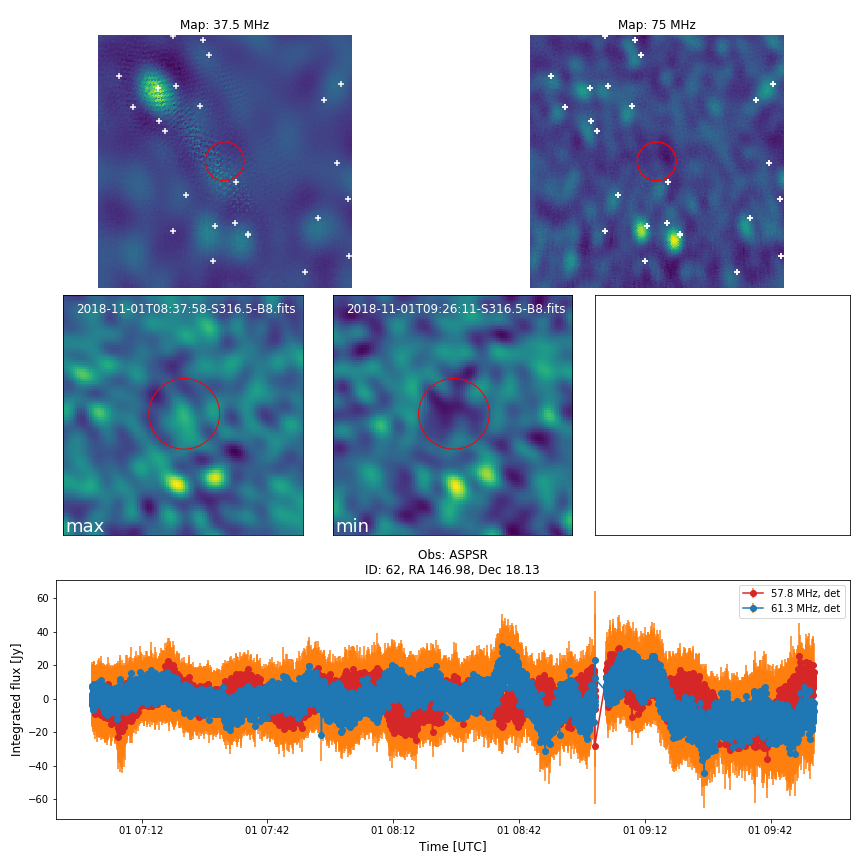

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


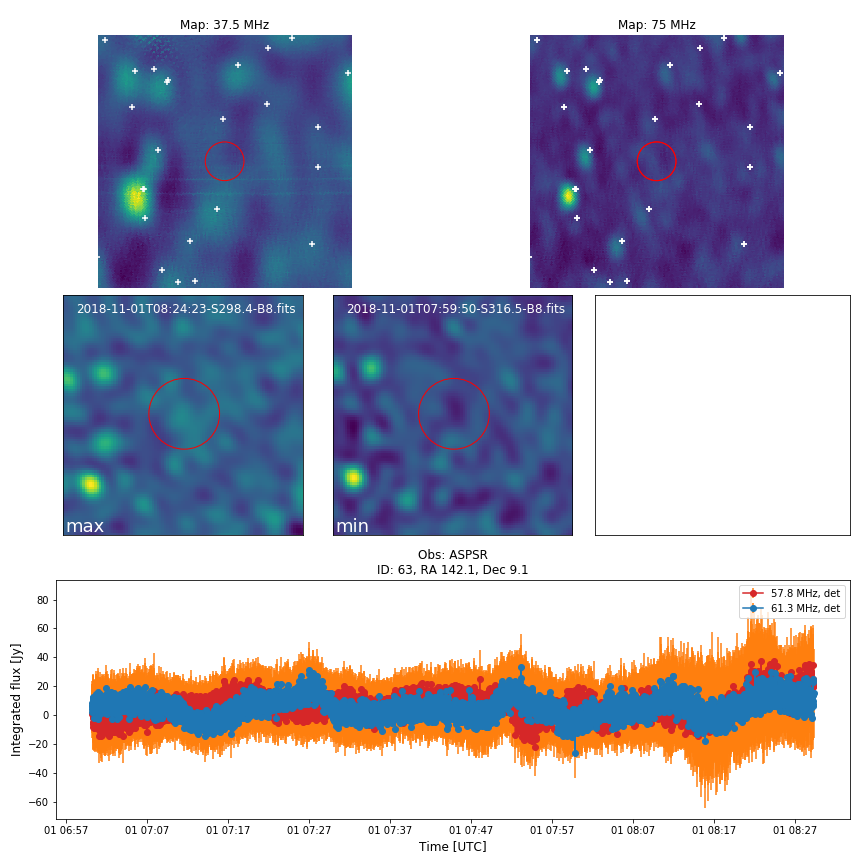

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


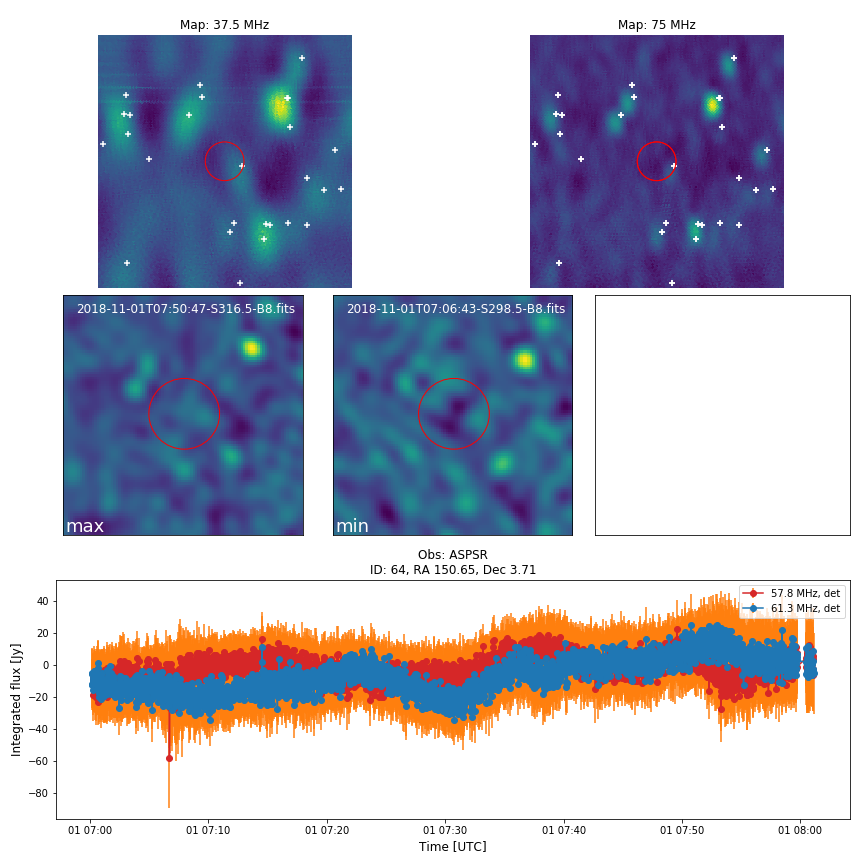

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


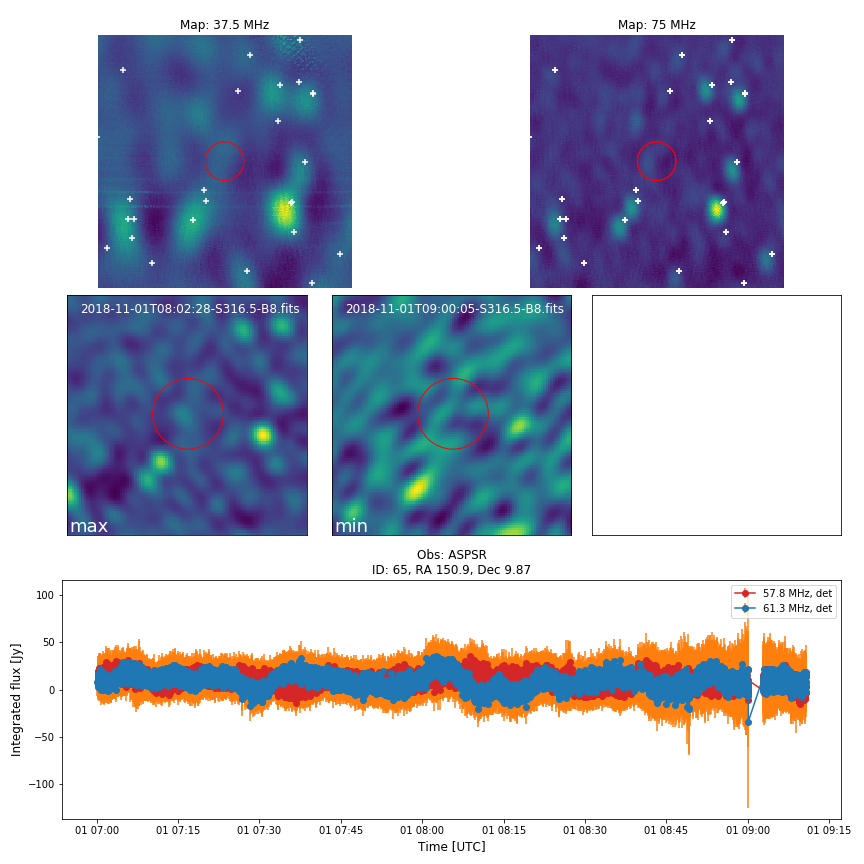

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


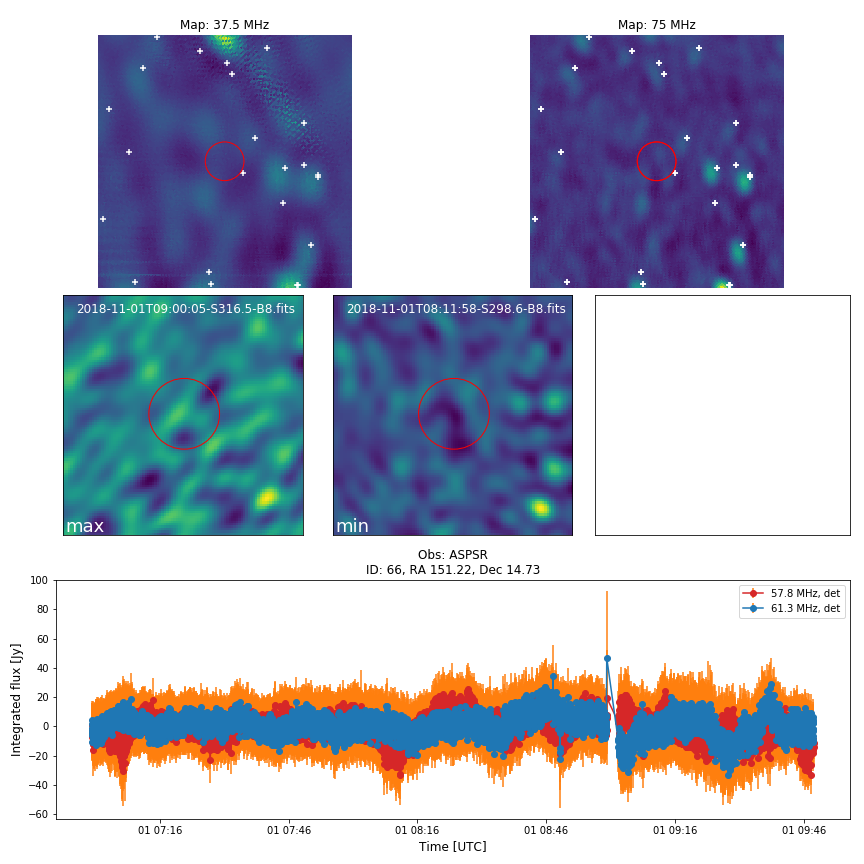

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


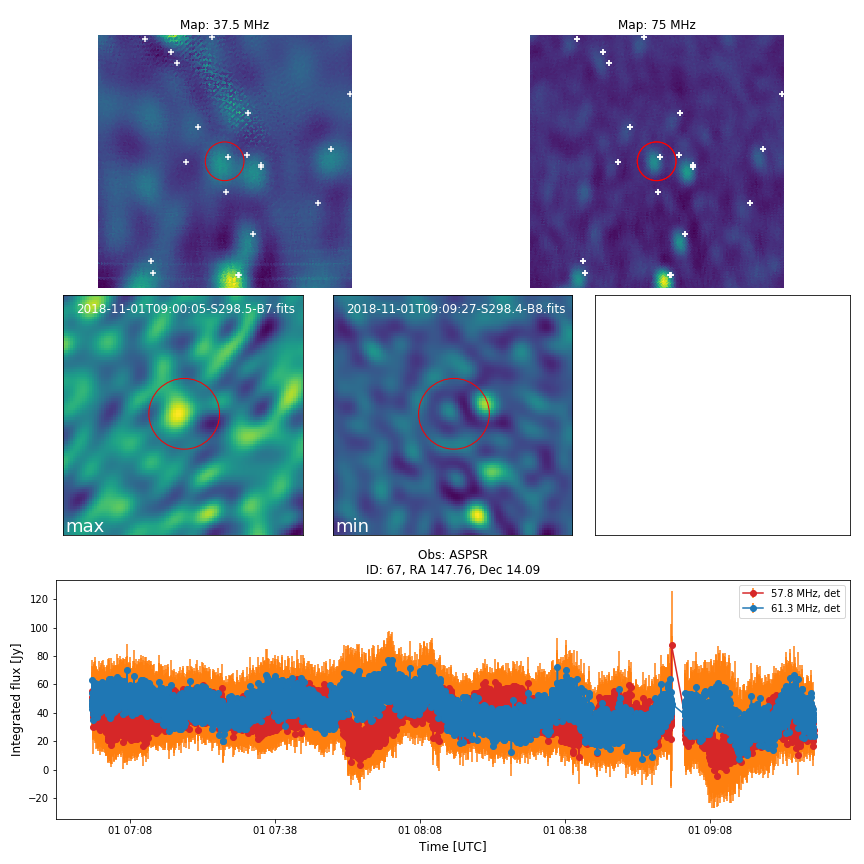

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


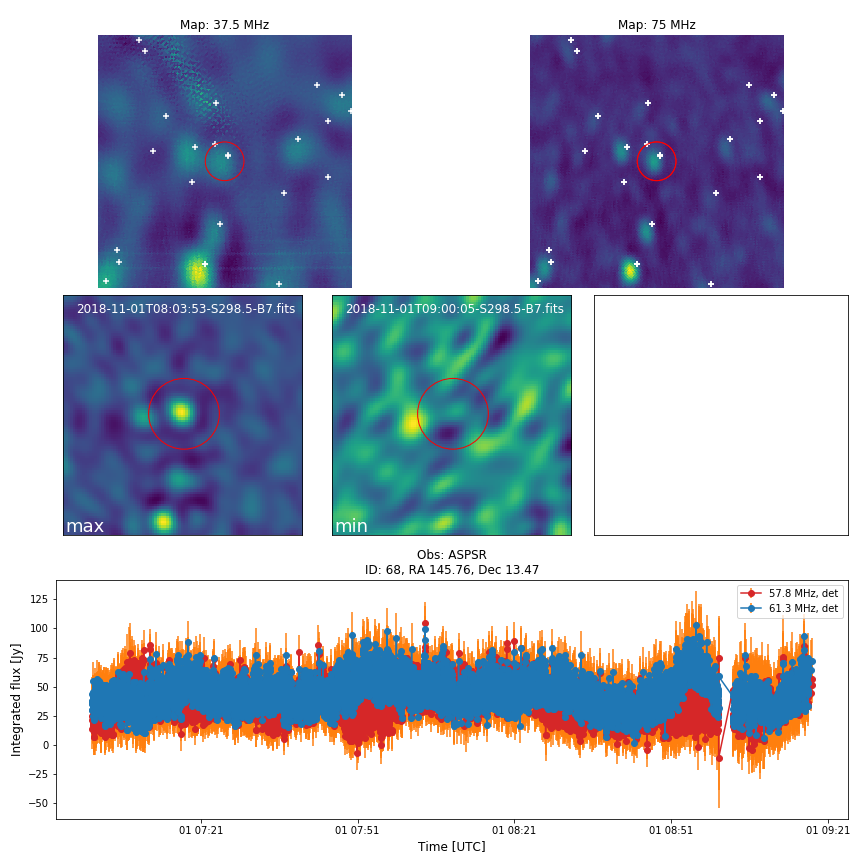

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


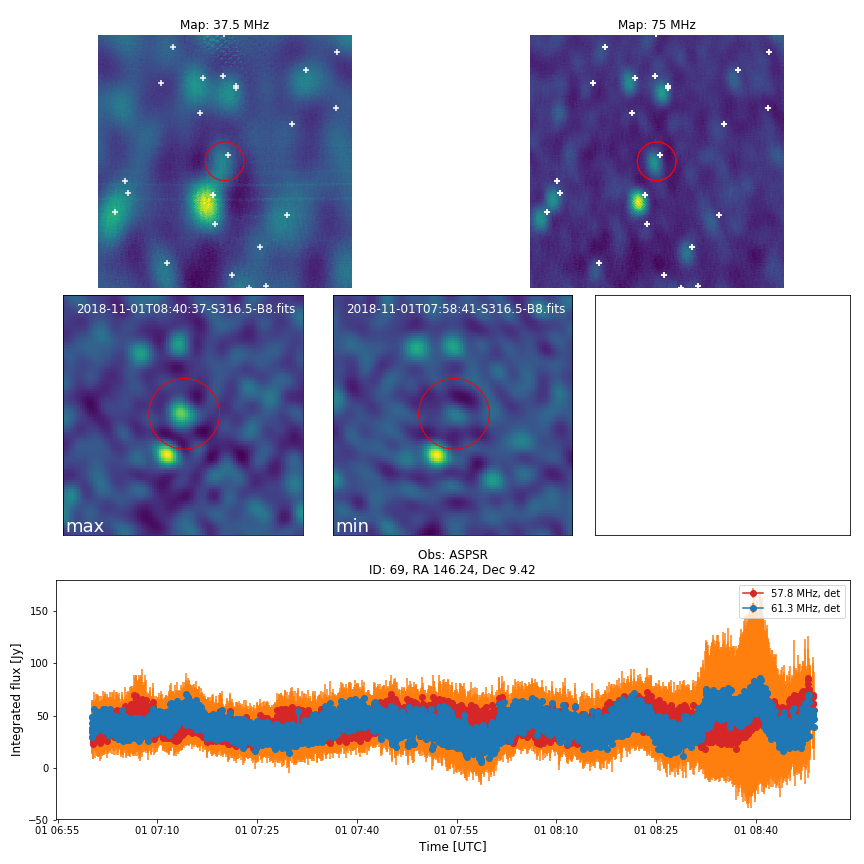

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


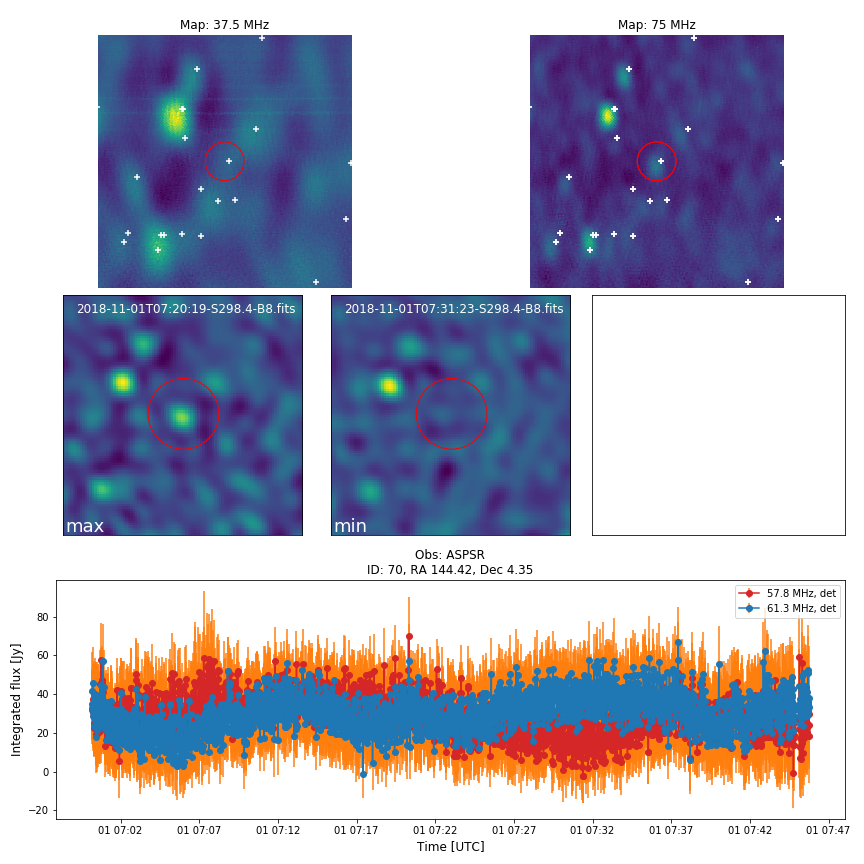

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


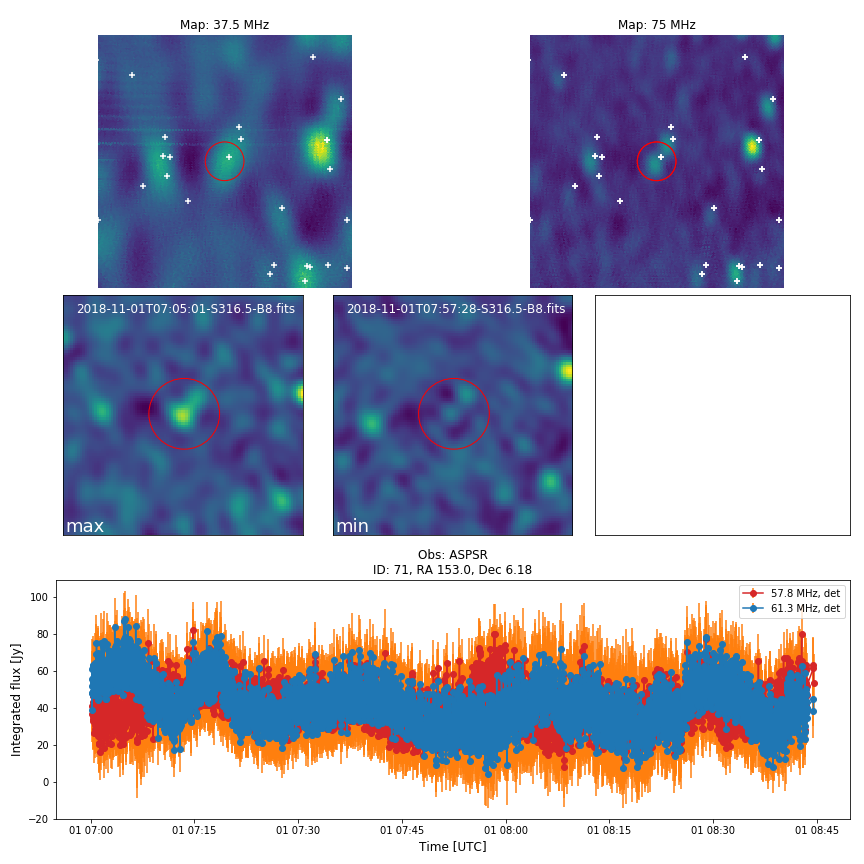

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


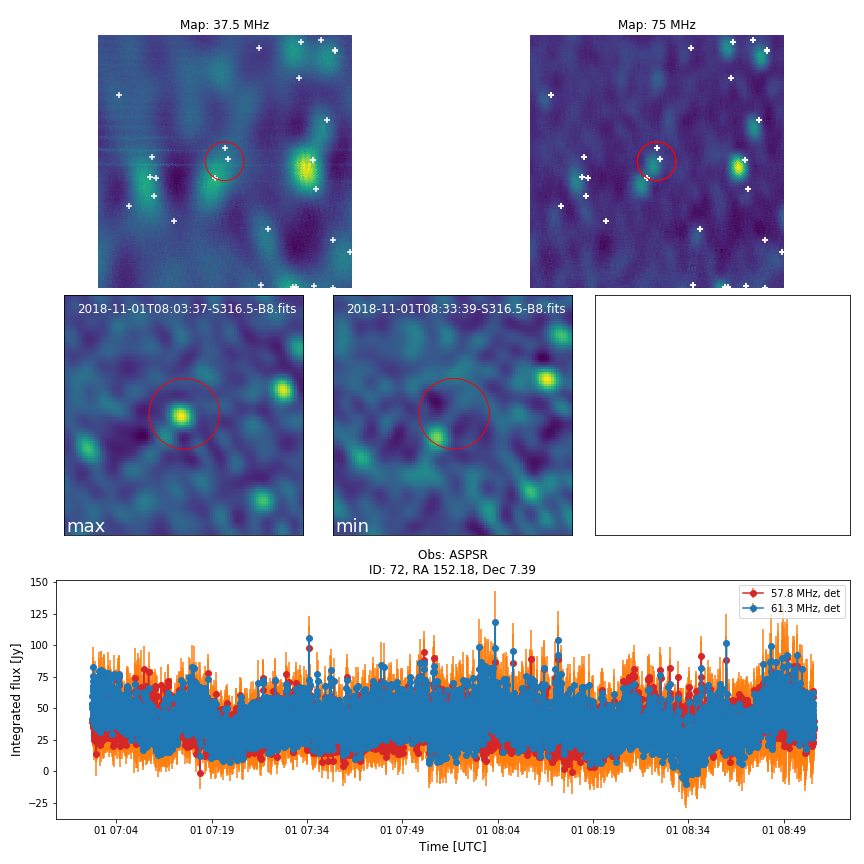

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


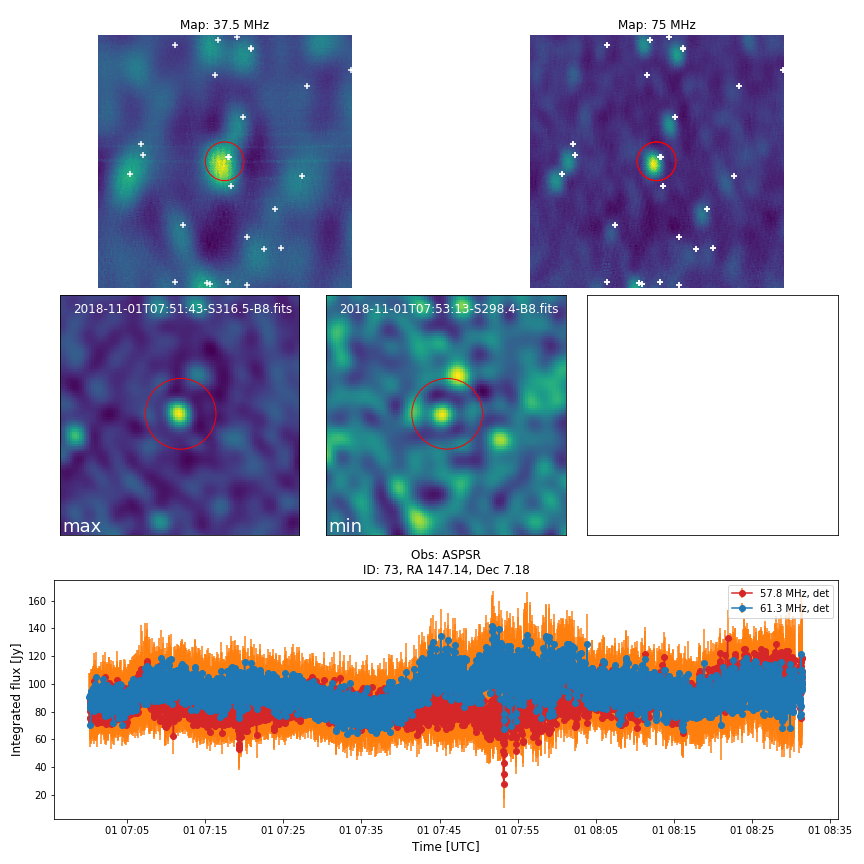

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


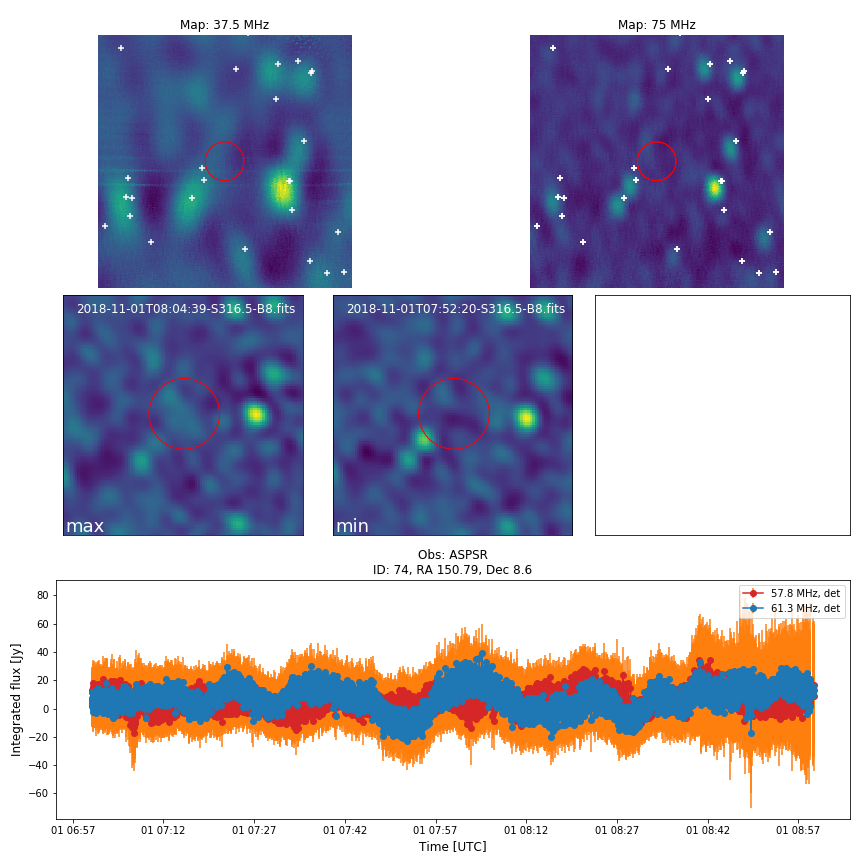

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


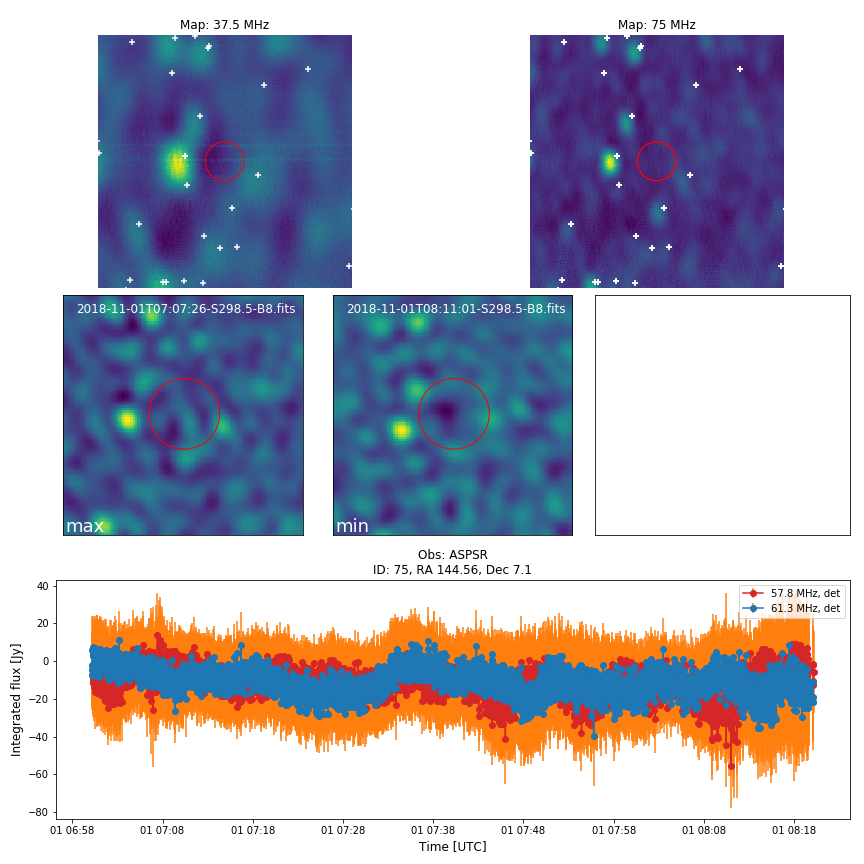

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


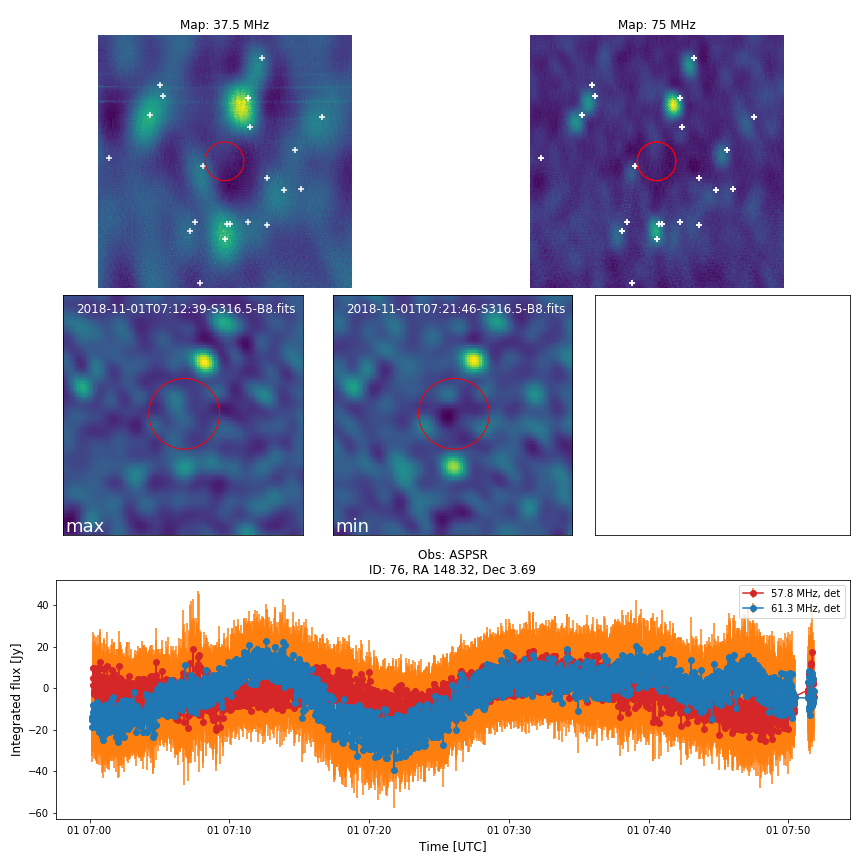

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


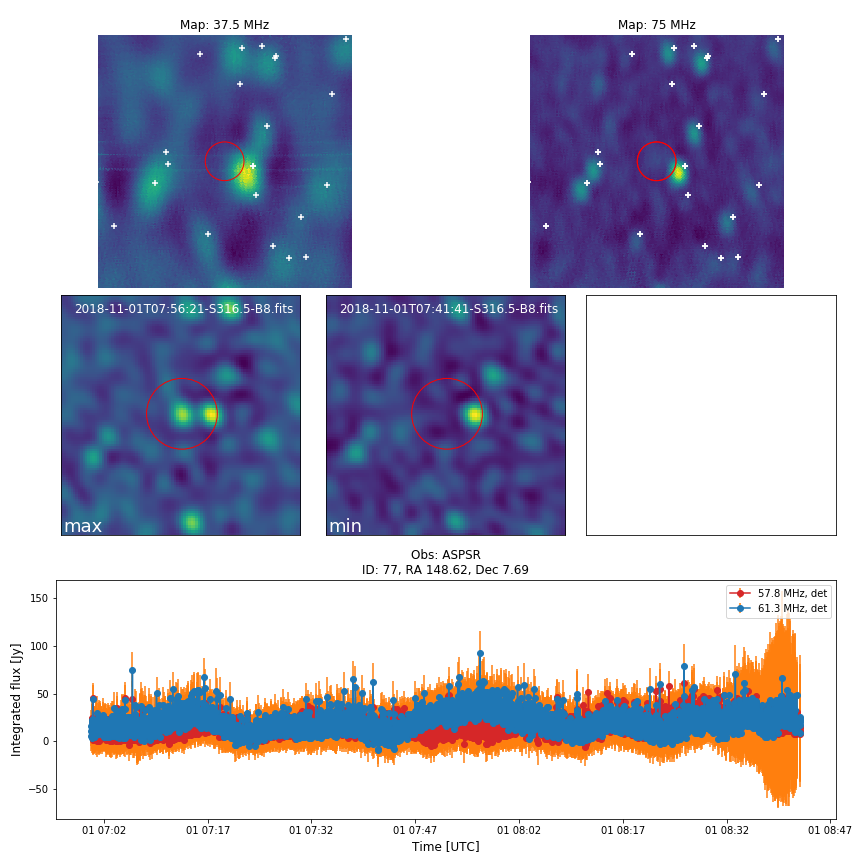

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


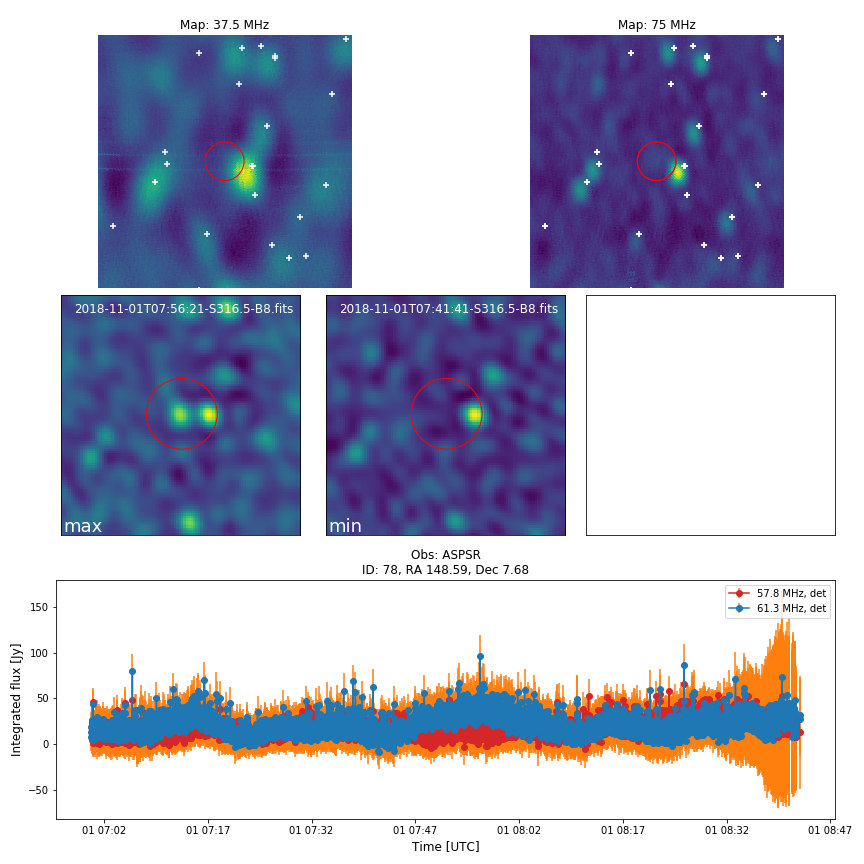

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


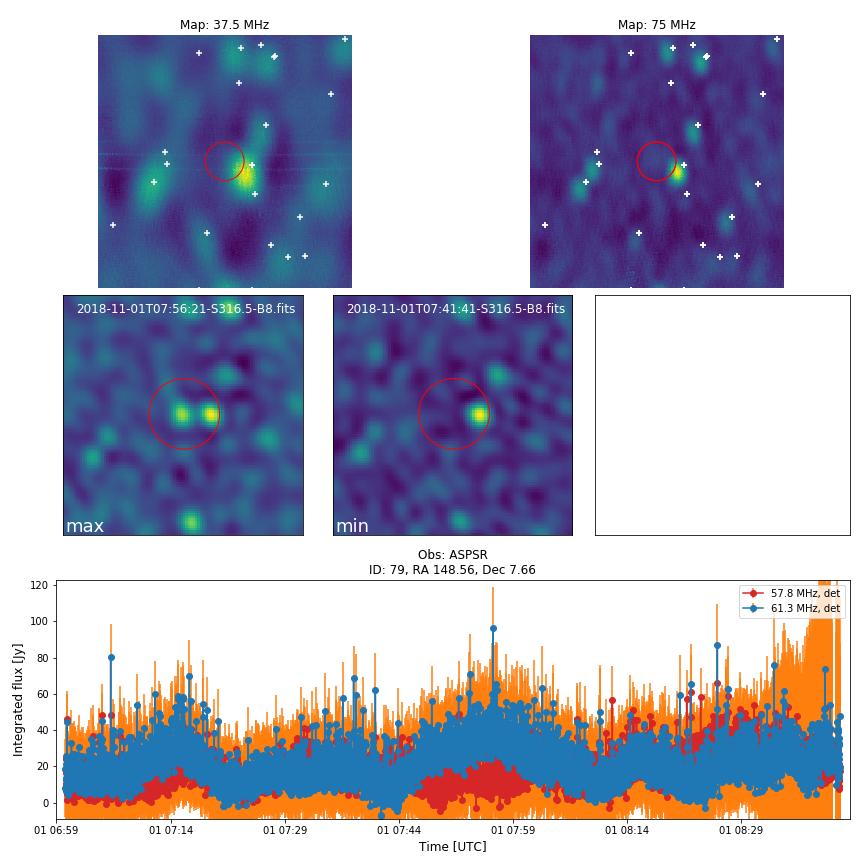

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [10]:
%matplotlib notebook

stamp_side = 600
half_side = int(stamp_side/2)

x = np.linspace(0, stamp_side, stamp_side)
y = np.linspace(0, stamp_side, stamp_side)
x, y = np.meshgrid(x, y)


map_dir = "/home/kuiack/skymaps/"
files = glob.glob(map_dir+"*.fits")
BANDS = [os.path.basename(i)[:4] for i in files]

delta = 100 
vlssr_thresh= 5
# i = 3

# source_df = retrieve_source(data, trans_data.runcat.iloc[i])

# print trans_data.runcat.iloc[i]
# del source_df

# 2579, 2460, 1260, 1985

# run_index = 2579 #np.unique(reduced.runcatid)[653]

fig_n = 1


IDS = np.unique(data[data.extract_type == 2].runcatid)
for _ID in IDS:#np.unique(data[data.extract_type == 2].runcatid):#pass_list:#AART_catsource.index:

    source_df = retrieve_source(data, _ID)[:-1]



    _source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
    _index = source_df.extract_type[(source_df.freq_eff < 60000000) ].values
    _source_flux[(_index == 1)] = np.nan


    plt.figure(fig_n,figsize=(12,12))
    map_load = hp.fitsfunc.read_map(map_dir+BANDS[2]+"_512_map.fits")
    stamp = hp.gnomview(map_load,  xsize=stamp_side,
                        rot=([r_data.loc[_ID].ra,
                              r_data.loc[_ID].decl]),
                        coord="C", return_projected_map=True,
                        fig=fig_n,sub=322,notext=True, title="Map: 75 MHz",cbar=False)

    hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                   marker="+", color="white", coord="C")

    hp.projscatter(r_data.loc[_ID].ra,
                   r_data.loc[_ID].decl,lonlat=True,
                   edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)

    map_load = hp.fitsfunc.read_map(map_dir+BANDS[3]+"_512_map.fits")

    stamp = hp.gnomview(map_load, xsize=stamp_side,
                        rot=([r_data.loc[_ID].ra,
                              r_data.loc[_ID].decl]),
                        coord="C", return_projected_map=True, fig=1,sub=321, 
                        notext=True, title="Map: 37.5 MHz",cbar=False)


    hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                   marker="+", color="white", coord="C")

    hp.projscatter(r_data.loc[_ID].ra,
                   r_data.loc[_ID].decl,lonlat=True,
                   edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)


    plt.subplot(313)

    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
                 _source_flux, 
                 yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
                 fmt="o-", color="C3",ecolor="C1", label="57.8 MHz, det")

    del _source_flux

    if len(source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values) > 0:
        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                     source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
                     yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                     fmt=".", color="C3",ecolor="C1", label="57.8 MHz, ff")

    # plt.ylim([0,80])
    _source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
    _index = source_df.extract_type[(source_df.freq_eff > 60000000) ].values
    _source_flux[(_index == 1)] = np.nan

    # plt.figure(figsize=(24,8))
    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
                 _source_flux, 
                 yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) ].values,
                 fmt="o-",color="C0", ecolor="C1", label="61.3 MHz, det")

    del _source_flux

    if len(source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values) > 0:
        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                     source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
                     yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                     fmt=".", color="C0",ecolor="C1", label="61.3 MHz, ff")


    plt.legend()
    plt.ylabel("Integrated flux [Jy]")
    plt.xlabel("Time [UTC]")
    # plt.xlim([source_df.taustart_ts[source_df.freq_eff > 60000000].values[0],
    #          source_df.taustart_ts[source_df.freq_eff > 60000000].values[10]])

    # plt.xlim([datetime.datetime(year=2017, month=2, day=25,hour=1 , minute=48, second=0),
    #           datetime.datetime(year=2017, month=2, day=25,hour=1 , minute=58, second=0)])

    # plt.savefig("/home/kuiack/scintilation_source.pdf")
#     plt.tight_layout()
    plt.title("Obs: AS"+dbname+"\nID: "+str(_ID)+", RA "+str(round(source_df.ra.mean(),2))+", Dec "+str(round(source_df.decl.mean(),2)))
    
    
    plt.subplot(3,3,4)
    if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.max()].url[0]):
        filename = source_df[ source_df.f_int == source_df.f_int.max()].url[0]
    elif os.path.isfile("/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[3]+"/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])): 
        filename = "/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[3]+"/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])
    else: 
        filename = "/data/AS_20181101-PSR_0950_flux/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])

        
    wcs = WCS(filename)
    im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

    pos = [im_pix_x, im_pix_y]

    plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
    plt.text(0.5,0.5,"max", color="white", fontsize=18)
    plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
    plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")

    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,3,5)
    if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.min()].url[0]):
        filename = source_df[ source_df.f_int == source_df.f_int.min()].url[0]
    elif os.path.isfile("/mnt/"+source_df[ source_df.f_int == source_df.f_int.min()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.min()].url[0].split("/")[3]+"/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])): 
        filename = "/mnt/"+source_df[ source_df.f_int == source_df.f_int.min()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.min()].url[0].split("/")[3]+"/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])
    else: 
        filename = "/data/AS_20181101-PSR_0950_flux/"+os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])

    wcs = WCS(filename)
    im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

    pos = [im_pix_x, im_pix_y]

    plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
    plt.text(0.5,0.5,"min", color="white", fontsize=18)
    plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
    plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,3,6)
    plt.plot()
    plt.xticks([])
    plt.yticks([])
    
#     plt.figure(figsize=(10,8))
#     plt.title(str(_ID)+" v_int")
#     plt.plot(source_df.v_int[(source_df.freq_eff < 60000000)], ".",label="57.8 MHz")
#     plt.plot(source_df.v_int[(source_df.freq_eff > 60000000)], ".",label="61.3 MHz")
#     plt.legend()
    
#     plt.figure(figsize=(10,8))
#     plt.title(str(_ID)+" eta")
#     plt.plot(source_df.eta_int[(source_df.freq_eff < 60000000)], ".", label="57.8 MHz")
#     plt.plot(source_df.eta_int[(source_df.freq_eff > 60000000)], ".", label="61.3 MHz")
#     plt.legend()
    plt.tight_layout()
    plt.show()
    fig_n +=1
#     plt.figure(figsize=(12,6))
#     plt.plot(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
#                  source_df.v_int[(source_df.freq_eff > 60000000) ].values, 
#                  color="C5",  label="High band, det")
#     plt.ylabel("V_int")
#     plt.xlabel("Time [UTC]")
#     # plt.xlim([datetime.datetime(year=2017, month=2, day=25,hour=3 , minute=48, second=0),
#     #           datetime.datetime(year=2017, month=2, day=25,hour=4 , minute=10, second=0)])


#     # if _ID == 2578:
#     #     plt.ylim([0,300])

#     # del source_df       
#     #     
#     plt.show()



<IPython.core.display.Javascript object>


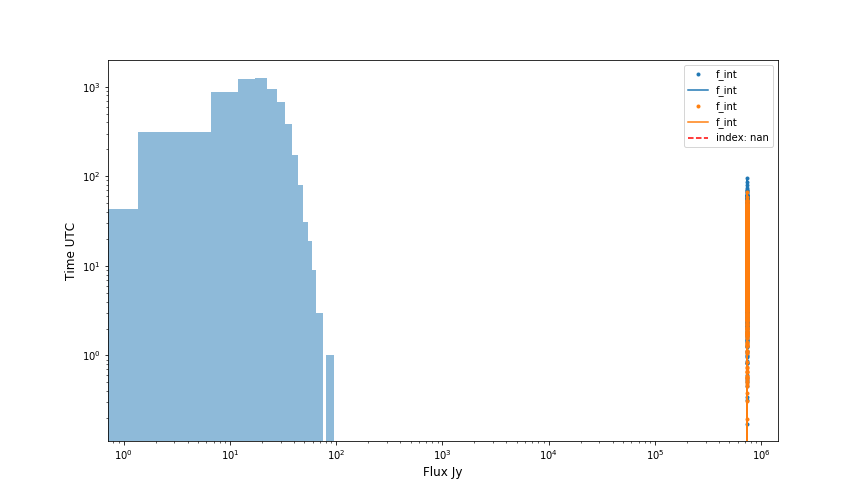

In [37]:
%matplotlib notebook

source_df = retrieve_source(data, 78)[:-1]

plt.figure(figsize=(12,7))
plt.plot(source_df[(source_df.freq_eff > 60000000) ].f_int, ".", c="C0")
plt.plot(source_df[(source_df.freq_eff > 60000000) ].f_int, c="C0" )
plt.plot(source_df[(source_df.freq_eff < 60000000) ].f_int, ".", c="C1")
plt.plot(source_df[(source_df.freq_eff < 60000000) ].f_int,  c="C1")
plt.ylabel("Time UTC")
plt.xlabel("Flux Jy")
plt.show()

<IPython.core.display.Javascript object>


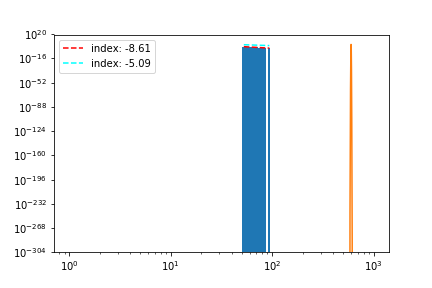

In [157]:
def powlaw(x,a,b):
    return a*x**b

plt.figure()
n, bins, patches = plt.hist(source_df[(source_df.freq_eff > 60000000) & (source_df.f_int > 50)].f_int, 
                            log=True, bins=10)
plt.xscale("log")

bin_l = bins[1:] - (bins[1:]-bins[:-1])/2
fit, cov = curve_fit(powlaw, bin_l, n)


plt.plot(bin_l,powlaw(bin_l,fit[0],fit[1]), "--", c="r", 
         label="index: {}".format(round(fit[1],2)))
plt.plot(bin_l,powlaw(bin_l,fit[0]/1500.,-5.09), "--", c="cyan", 
         label="index: {}".format(round(-5.09,2)))
plt.legend()


In [122]:
fit

array([  1.95532073e+16,  -8.60791335e+00])

In [99]:
a

array([ 1.04738252,  2.14162198])

<IPython.core.display.Javascript object>


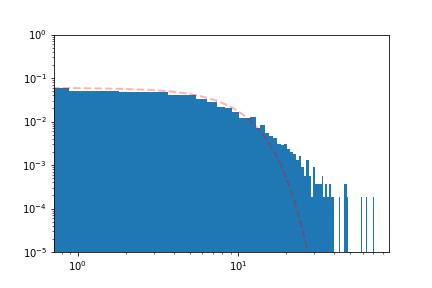

6.63429952184


<IPython.core.display.Javascript object>


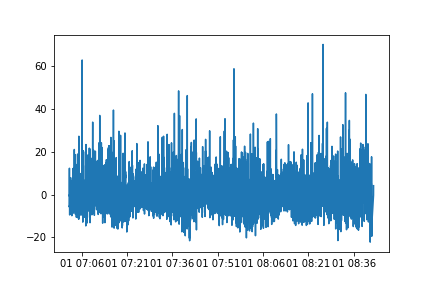

In [53]:
from scipy.stats import norm

lightcurve = source_df[(source_df.freq_eff > 60000000) ].f_int
cleaned = lightcurve-lightcurve.rolling(100).mean()
cleaned = cleaned[~np.isnan(cleaned)]

plt.figure()
n, bins, patches =  plt.hist(cleaned, bins=100, normed=1)


(mu, sigma) = norm.fit(clip(cleaned))
print sigma
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2, alpha=0.3)
plt.xscale("log")
plt.yscale("log")

plt.show()
plt.figure()
plt.plot(cleaned)
plt.show()

In [10]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

Smirnova 
peak: 2 Jy 	FWHM: 15.0 ms
fluence: 31.9020765724 Jy ms

AARTFAAC, using WSRT width at 111 MHz (Singal % Vats)
peak: 90000 Jy 	FWHM: 1.0 ms
fluence: 91269.6011398 Jy ms

AARTFAAC, using LWA range at 39 to 74 MHz (Tsai)
peak: 17000 Jy 	FWHM: 5.0 ms
fluence: 90389.216955 Jy ms


peak: 4950 Jy 	FWHM: 17.2 ms
fluence: 90538.0933123 Jy ms


peak: 2850 Jy 	FWHM: 30.0 ms
fluence: 90920.9182312 Jy ms


(0, 10)

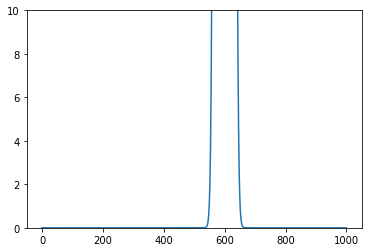

In [9]:

x = np.linspace(0,1000, 1000)
# giant pulse width is much narrower than AP 


peak = 2
FWHM = 15.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "Smirnova "
print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"

print "\nAARTFAAC, using WSRT width at 111 MHz (Singal % Vats)"

peak = 90000
FWHM = 1.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))


print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"



print "\nAARTFAAC, using LWA range at 39 to 74 MHz (Tsai)"

peak = 17000
FWHM = 5.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"

peak = 4950
FWHM = 17.2

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "\n"
print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"


peak = 2850
FWHM = 30.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "\n"
print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"



plt.plot(x,y)
# plt.xlim([599.5,600.5])
plt.ylim([0,10])

In [64]:
print "\nAARTFAAC, using LWA range at 39 to 74 MHz (Tsai)"

peak = 26500
FWHM = 5.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
print "fluence:", np.sum(y), "Jy ms"

peak = 7700
FWHM = 17.2

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "\n"
print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"


peak = 4400
FWHM = 30.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 200, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 400, 20./(2*np.sqrt(2*np.log(2))))
# y += gaussian(x, 2.5, 800, 20./(2*np.sqrt(2*np.log(2))))

print "\n"
print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
# print np.average(y)
print "fluence:", np.sum(y), "Jy ms"



AARTFAAC, using LWA range at 39 to 74 MHz (Tsai)
peak: 26500 Jy 	FWHM: 5.0 ms
fluence: 141041739.033 Jy ms


peak: 7700 Jy 	FWHM: 17.2 ms
fluence: 140977871.075 Jy ms


peak: 4400 Jy 	FWHM: 30.0 ms
fluence: 140509506.055 Jy ms


peak: 132000 Jy 	FWHM: 1 ms
fluence: 140509.506055 Jy ms


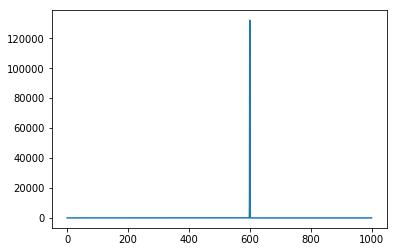

In [11]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

peak = 132000
FWHM = 1

x = np.linspace(0,1000, 1000000)

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))
plt.figure()
plt.plot(x,y)

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
print "fluence:", np.sum(y)/1000., "Jy ms"

In [62]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

peak = 13152
FWHM = 10

x = np.linspace(0,1000, 1000000)

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
print "fluence:", np.sum(y)/1000., "Jy ms"

peak = 81.2
FWHM = 12.8

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
print "fluence:", np.sum(y)/1000., "Jy ms"


peak = 2.6
FWHM = 20.

y = gaussian(x, peak, 600, FWHM/(2*np.sqrt(2*np.log(2))))

print "peak:", peak,"Jy","\t", "FWHM:", FWHM, "ms"
print "fluence:", np.sum(y)/1000., "Jy ms"

peak: 13152 Jy 	FWHM: 10 ms
fluence: 139998.562397 Jy ms


### Remake fig 11 form Tsai et al. comparing all the AP and GP fluxes 

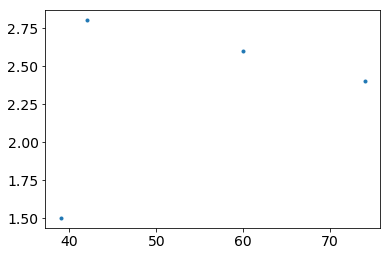

In [32]:
# 

plt.plot([39,42,60,74],[1.5,2.8,2.6,2.4],".")

### Pulse dispersion sweep 

In [10]:
def dm_delay(f1,f2,dm):
    return 4.15*10**3*(f2**(-2)-f1**(-2))*dm

# DM is 2.99 for PSR 0950+08
# Period is 0.25 seconds 

In [8]:


step = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 
                 18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.], dtype=int)
freqs = 57.6171875 + 0.2*step

dm_delay(freqs, 57.6171875,2.99)

array([ 0.        ,  0.02581466,  0.05136281,  0.07664811,  0.10167415,
        0.12644446,  0.15096252,  0.17523173,  0.42669054,  0.44822009,
        0.46954033,  0.49065398,  0.51156368,  0.53227206,  0.5527817 ,
        0.57309513])

Text(0,0.5,'Frequency [MHz]')

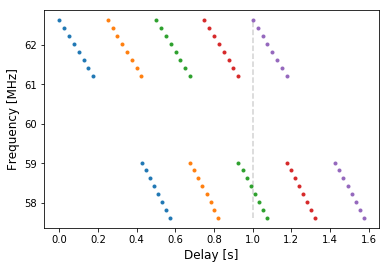

In [39]:
plt.plot( [1.0,1.0],[np.min(freqs),np.max(freqs)], "--", c="lightgrey")
plt.plot(dm_delay(freqs, 57.6171875,2.99)[::-1], freqs, ".")
plt.plot(dm_delay(freqs, 57.6171875,2.99)[::-1]+0.25, freqs, ".")
plt.plot(dm_delay(freqs, 57.6171875,2.99)[::-1]+0.50, freqs, ".")
plt.plot(dm_delay(freqs, 57.6171875,2.99)[::-1]+0.75, freqs, ".")
plt.plot(dm_delay(freqs, 57.6171875,2.99)[::-1]+1.00, freqs, ".")

plt.xlabel("Delay [s]")
plt.ylabel("Frequency [MHz]")

In [40]:
print "hello"

hello


### rotation energy efficiency % from these pulses

## Uptime

In [10]:
uptime = pd.read_csv("~/PSR_0950_uptime.csv")

In [20]:
print uptime.timestamps.sum()/60./60., "hours"
print uptime.timestamps.sum()* 4, "pulses"

35.1230555556 hours
505772 pulses


In [11]:
ls /home/kuiack/PSR_0950+08/


PSR_201611120632.csv  PSR_20181025.csv  PSR_ASf_20181103.csv
PSR_201611140501.csv  PSR_20181026.csv  PSR_ASf_20181104.csv
PSR_201810170300.csv  PSR_20181027.csv  PSR_ASf_20181105.csv
PSR_201810210800.csv  PSR_20181028.csv  PSR_ASf_20190101.csv
PSR_20181024.csv      PSR_20181101.csv


In [11]:
count = 0 
for i in glob.glob("/home/kuiack/PSR_0950+08/*csv"):
    if count == 0:
        one = pd.read_csv(i, delimiter="|")
    else:
        one = pd.concat([one,pd.read_csv(i, delimiter="|")])
    count += 1
    
one = one.rename(columns=lambda x: x.strip())

In [12]:
count = 0 
for i in glob.glob("/home/kuiack/PSR_0950+08/*corr"):
    if count == 0:
        one = pd.read_csv(i)
        one["dbname"] = pd.Series(len(one)*[i.split("-")[1]], index=one.index)
    else:
        two = pd.read_csv(i)
        two["dbname"] = pd.Series(len(two)*[i.split("-")[1]], index=two.index)

        one = pd.concat([one,two])
    count += 1
    
one = one.rename(columns=lambda x: x.strip())

In [21]:
uptime["n_detections"] = pd.Series(np.zeros(len(uptime)), index = uptime.index)

for obser in uptime.obs:
    uptime["n_detections"].loc[uptime.obs == obser] += len(one[one.dbname == obser])

In [24]:
len(uptime[(uptime.timestamps > 10)  & (uptime.n_detections > 0) ])/ float(len(uptime[(uptime.timestamps > 10)]))



0.6363636363636364

In [35]:
uptime["rate n/t"] = uptime.n_detections/uptime.timestamps
    
    
    
    

In [36]:
uptime[(uptime.timestamps > 10)]

obs  timestamps            starttime              endtime  \
2   _201609070340        3690  2016-09-07T03:40:10  2018-09-07T17:23:05   
3   _201611120632        4219  2016-11-12T06:32:11  2016-11-12T14:30:57   
5   _201611140501        9270  2016-11-14T05:01:10  2016-11-14T08:59:56   
17  _201809220609        2908  2018-09-22T06:09:11  2018-09-22T09:48:50   
19  _201809230412        4943  2018-09-23T04:12:11  2018-09-23T08:57:56   
20  _201809280900        5050  2018-09-28T09:18:54  2018-09-28T16:08:13   
22  _201809290600        2820  2018-09-29T06:00:10  2018-09-29T07:58:57   
24  _201810170300       12429  2018-10-17T03:00:10  2018-10-17T10:58:57   
25  _201810210800        4348  2018-10-21T08:00:10  2018-10-22T13:03:04   
27      _20181024        7194  2018-10-16T20:00:10  2018-10-31T16:46:11   
28      _20181025        7005  2018-10-25T07:00:10  2018-10-25T14:58:57   
29      _20181026        6769  2018-10-01T13:35:03  2018-10-26T14:58:57   
30      _20181027        6533  2018-10-27T07:00:10  2018-11-01T14:26:06   
31      _20181028        2696  2018-10-28T08:00:11  2018-10-28T13:58:57   
32      _20181029        6050  2018-10-29T07:00:21  2018-10-29T14:58:57   
33      _20181101        5343  2018-11-01T07:00:10  2018-11-01T16:19:28   
34      _20181102        1517  2018-11-02T08:00:10  2018-11-08T18:37:29   
35   ASf_20181103        1281  2018-11-03T08:00:10  2018-11-03T15:57:57   
36   ASf_20181104        7151  2018-11-04T06:16:11  2018-12-06T08:52:46   
37   ASf_20181105       11895  2018-11-05T04:53:11  2018-11-05T15:57:57   
38   ASf_20181231         983  2018-12-31T04:17:00  2018-12-31T16:28:57   
39   ASf_20190101       12343  2019-01-01T00:22:00  2019-01-01T08:37:57   

    n_detections  rate n/t  
2            0.0  0.000000  
3            3.0  0.000711  
5           10.0  0.001079  
17           0.0  0.000000  
19           0.0  0.000000  
20           0.0  0.000000  
22           0.0  0.000000  
24          46.0  0.003701  
25           6.0  0.001380  
27           3.0  0.000417  
28           8.0  0.001142  
29           8.0  0.001182  
30           4.0  0.000612  
31           3.0  0.001113  
32           0.0  0.000000  
33          25.0  0.004679  
34           0.0  0.000000  
35          11.0  0.008587  
36           7.0  0.000979  
37           5.0  0.000420  
38           0.0  0.000000  
39          16.0  0.001296

max: 2566.14284123 min 833.125374726
[  2.49952452e-04  -4.63336566e+00]


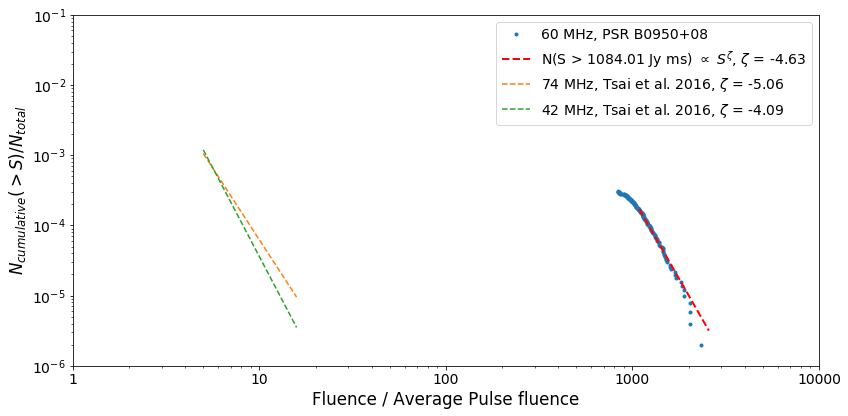

In [18]:
def powlaw(x,a,b):
    return a*x**b

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }


matplotlib.rc('font', **font)

from matplotlib.ticker import ScalarFormatter


x = (np.sort(one['f_int_cal'].values) *1000.)/55.35

print "max:", np.max(x), "min", np.min(x)



y = np.array((np.array(range(len(one['f_int_cal'].values))[::-1])))/(4.*uptime[uptime.timestamps > 10].timestamps.sum())

flux_limit = 60000/55.35

fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])

print fit

fig1, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(x,y, ".", label="60 MHz, PSR B0950+08")

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")
ax1.set_xlabel("Fluence / Average Pulse fluence")
ax1.set_xlim([1,10000])
ax1.set_ylim([1e-6,0.1])

# ax1.set_xticks([50,80,100, 120,140] )

# for axis in [ax1.xaxis, ax1.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_major_formatter(ScalarFormatter())

ax1.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)]/1000.,fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))


ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),13., -4.09), "--", 
         label="74 MHz, Tsai et al. 2016, "r"$\zeta$ = -5.06"  )



ax1.plot(np.logspace(1,1.5)/2., powlaw(np.logspace(1,1.5),137., -5.06),"--", 
         label="42 MHz, Tsai et al. 2016, "r"$\zeta$ = -4.09")


ax1.legend()
plt.tight_layout()
# plt.savefig("/home/kuiack/Ngt60.png")



### 
# flux_limit = 70.
# fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)])
# fig1, ax1 = plt.subplots(figsize=(6,6))

# ax1.plot(x,y, ".", label="60 MHz, PSR B0950+08")
# ax1.set_xscale("log")
# ax1.set_yscale("log")
# ax1.set_ylabel(r"$N_{cumulative}( > S)/N_{total}$")


# # ax1.set_xlabel("Flux density [Jy]")
# ax1.set_xlabel("Fluence [Jy sec]")

# # ax1.set_xticks([50,80,100, 120,140] )
# # for axis in [, ax1.yaxis]:
# ax1.xaxis.set_major_formatter(ScalarFormatter())


# ax1.plot(x[(x > flux_limit)],
#          powlaw(x[(x > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
#          label="N(S > {} Jy )"r"$\propto$"r"$S^\zeta$"", "r"$\zeta$"" = {}".format( flux_limit, 
#                                                         round(fit[1],2), 
#                                                         flux_limit))
# # ax1.set_xticks([50,80,100, 120,140] )
# ax1.legend()




In [37]:
print np.array((np.array(range(len(one['f_int_cal'].values))[::-1])))
print 1./(4.*uptime[uptime.timestamps > 10].timestamps.sum())


[154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138 137
 136 135 134 133 132 131 130 129 128 127 126 125 124 123 122 121 120 119
 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101
 100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84  83
  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66  65
  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48  47
  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30  29
  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12  11
  10   9   8   7   6   5   4   3   2   1   0]
1.97726931199e-06


[  752.87329781   759.04543895   759.7546261    763.2078544    763.42294146
   765.57828781   767.32796859   768.23185357   770.75037948   777.88837418
   779.16090988   787.42870989   792.71356439   814.4596798    816.89601798
   817.20124924   824.74736248   825.73541192   833.05883497   834.53210236
   835.99745006   841.38861443   843.61925622   844.05122649   848.04694966
   848.13566407   854.29393397   855.15848453   855.68191136   857.88409419
   858.61479755   861.88409096   865.05268241   871.32753762   871.38518883
   874.49032576   878.62971559   882.4023215    885.38164569   886.30553193
   888.91538528   894.0931404    894.10768595   900.54119709   901.9780181
   905.09393774   912.59429061   915.45079524   916.60549629   920.34485702
   920.52618628   920.93737445   925.88726653   929.23886946   931.70980494
   931.82169477   932.34192964   937.85513602   939.05813106   941.29060352
   941.92756849   944.95365459   944.98193344   949.82980443   955.39471148
   961.752879

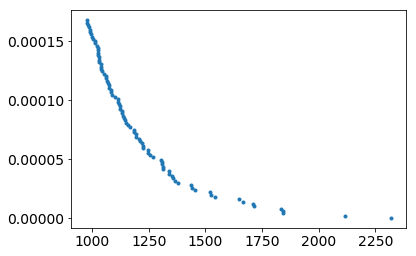

In [32]:
y = np.array((np.array(range(len(one['f_int_cal'].values))[::-1])))/(4.*uptime[uptime.timestamps > 10].timestamps.sum())


print x

plt.figure()
plt.plot(x[(x > flux_limit)], y[(x > flux_limit)], ".")
plt.show()


fit, cov = curve_fit(powlaw, x[(x > flux_limit)]/1000., y[(x > flux_limit)])




22
14


Text(0,0.5,'N GP detections')

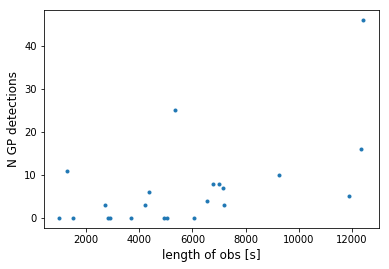

In [63]:
print len(uptime[uptime.timestamps > 10])
print len(uptime[(uptime.timestamps > 10) & (uptime.n_detections > 0)])


plt.plot(uptime[uptime.timestamps > 10].timestamps, 
         uptime[uptime.timestamps > 10].n_detections,".")

plt.xlabel("length of obs [s]")
plt.ylabel("N GP detections")

In [34]:
one.sort_values("f_int_cal")

f_int  det_sigma          ra      decl  band  \
5    42.397886   5.122319  148.556853  7.773221    24   
24   15.946425   5.183183  148.644782  7.642156    23   
2    15.965952   5.243691  148.508823  7.823496    24   
3    51.964519   5.141787  148.643703  7.683560    23   
2    16.984132   5.463313  148.556288  7.713931    23   
14   18.496912   5.131508  148.605936  7.714820    24   
10   48.062175   5.462431  148.584566  7.856461    23   
4    15.040938   5.063023  148.586316  7.841809    23   
1    44.879165   5.023136  148.560622  7.692880    24   
2    17.303887   5.337143  148.583143  7.515067    24   
35   15.753491   5.604887  148.659614  7.523015    23   
0    18.000848   5.729045  148.604679  7.688608    24   
0    16.754032   5.152491  148.641254  7.622666    23   
23   17.213110   5.495090  148.587849  7.584308    23   
34   14.015833   5.108064  148.700570  7.565728    23   
12   17.864246   5.233840  148.603217  7.749742    23   
2    47.862269   5.122126  148.523079  7.485392    23   
0    19.631367   5.655872  148.603514  7.568437    24   
0    17.336431   5.500112  148.619302  7.643263    24   
19   17.866680   5.084318  148.608269  7.679922    23   
6    19.193232   5.029054  148.591864  7.520377    23   
2    18.137529   5.207393  148.640092  7.696781    23   
2    48.676079   5.348864  148.621776  7.585266    23   
4    18.118750   5.343380  148.685358  7.766012    24   
3    17.769114   5.021112  148.661069  7.664656    24   
1    18.884588   5.219851  148.675875  7.519161    23   
5    18.289730   5.217721  148.636879  7.639528    24   
18   18.425942   5.425229  148.616528  7.756523    23   
8    18.420988   5.391473  148.583064  7.634721    23   
0    18.430638   5.819899  148.576007  7.825029    23   
..         ...        ...         ...       ...   ...   
5    22.921017   7.048998  148.544402  7.590257    23   
1   144.317289   5.190455  148.600288  7.785958    24   
9    84.105862   6.361666  149.023169  7.689642    23   
9    28.947275   8.586098  148.573164  7.713568    23   
42   27.500672   7.639994  148.399559  7.925633    24   
9   157.118226   6.315386  148.594767  7.669106    24   
11   97.319811   7.238381  148.766846  7.528336    24   
12   25.012609   7.383349  148.557866  7.635324    23   
37   30.233816   7.413680  148.303646  7.797931    24   
21   23.967739   6.799303  148.601965  7.735543    23   
44   26.218961   7.826301  148.009814  7.668849    24   
16   24.705282   6.200788  148.495743  7.726098    23   
15   25.778288   5.559518  148.629988  7.734137    23   
14   83.606288   8.362047  148.646488  7.663650    24   
14   25.484184   6.262314  148.613323  7.632322    23   
16   32.387344   8.110178  148.594681  7.782234    23   
9    27.251518   7.181904  148.564478  7.689109    23   
8    27.355805   7.923905  148.589960  7.688420    23   
38   28.284810   6.820441  148.413127  7.869634    23   
13   55.733063   5.253286  148.681431  7.526989    23   
3   100.267798   9.314706  148.304338  7.612135    23   
4   122.296506  10.024924  148.460575  7.639041    23   
8   108.144303   8.238684  148.586149  7.774205    23   
6    40.455916   9.193067  148.537272  7.771429    24   
7   112.835278   9.224145  148.359523  7.681868    23   
0   206.960344   8.289440  148.552656  7.670821    24   
4    34.380684  10.213527  148.562602  7.677875    23   
36   40.320437   9.596244  148.402163  7.792976    24   
11   38.873329  10.173938  148.534906  7.708104    23   
4   154.806046  12.808020  148.447250  7.608980    24   

                 taustart_ts   f_int_cal     slope  intercept         dbname  
5        2018-11-03 08:21:58   46.113489  1.114249  -8.984032   ASf_20181103  
24       2018-11-01 08:30:00   46.491533  0.379514  -1.697742      _20181101  
2        2018-10-17 06:24:28   46.534971  0.297237   2.134039  _201810170300  
3        2018-11-04 07:56:03   46.746481  1.111224   0.018709   ASf_20181104  
2        2018-11-01 07:05:02   46.759655  0.427175  -2.990439      _20181101  


In [76]:
print "number of 4 time number of timestamps (number of average pulses)  divided by number of detections "
print round(uptime[uptime.timestamps > 10].n_detections.sum()/\
            (4*uptime[uptime.timestamps > 10].timestamps.sum())*100,2), "% of pulses are GP"



number of 4 time number of timestamps (number of average pulses)  divided by number of detections 
0.03 % are GP


In [9]:
x = glob.glob("/home/kuiack/PSR_0950+08/*csv")
for i in x:
    dbname = i.split("-")[1]
    

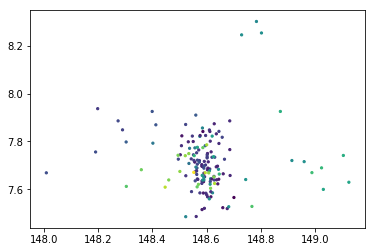

In [9]:
plt.scatter(one.ra, one.decl, c=np.log10(one.f_int), s=5)

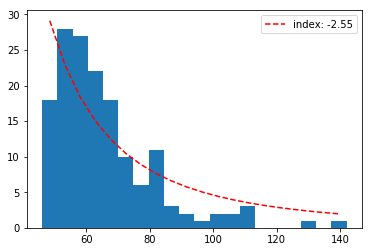

In [143]:
def powlaw(x,a,b):
    return a*x**b

plt.figure()
n, bins, patches = plt.hist(one['f_int_cal'], bins=20)
# plt.xscale("log")

bin_l = bins[1:] - (bins[1:]-bins[:-1])/2
fit, cov = curve_fit(powlaw, bin_l, n)

# plt.figure()
# n, bins, patches = plt.hist(one['f_int_cal'], bins=20, log=True)

plt.plot(bin_l,powlaw(bin_l,fit[0],fit[1]), "--", c="r", 
         label="index: {}".format(round(fit[1],2)))
plt.legend()
# plt.hist(one['    det_sigma     '], bins=30)
# # plt.xscale("log")
# plt.yscale("log")

In [82]:
100./(4.*uptime[uptime.timestamps > 10].timestamps.sum())

0.000197726931198937

In [144]:
x = np.random.normal(loc=0,scale=10.,size=1e9)

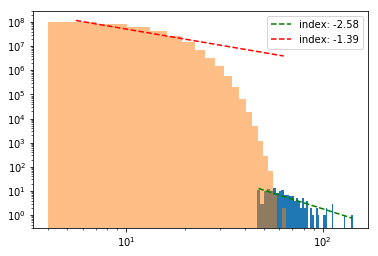

In [145]:
# plt.hist(x[x > 5],bins=30)

plt.figure()

# plt.figure()
n, bins, patches = plt.hist(one['f_int_cal'], bins=50, log=True)
plt.xscale("log")

bin_l = bins[1:] - (bins[1:]-bins[:-1])/2
fit, cov = curve_fit(powlaw, bin_l, n)

plt.plot(bin_l,powlaw(bin_l,fit[0],fit[1]), "--", c="g", 
         label="index: {}".format(round(fit[1],2)))


n, bins, patches = plt.hist(x[x > 4.], bins=20, log=True, alpha=0.5)
# plt.xscale("log")

bin_l = bins[1:] - (bins[1:]-bins[:-1])/2
fit, cov = curve_fit(powlaw, bin_l, n)

plt.plot(bin_l,powlaw(bin_l,fit[0],fit[1]), "--", c="r", 
         label="index: {}".format(round(fit[1],2)))

plt.legend()
plt.xscale("log")
plt.yscale("log")

In [16]:
flux = source_df[(source_df.freq_eff > 60000000) ].f_int

plt.figure()
n, bins, patches = plt.hist(flux, bins=40,alpha=0.5)
# plt.xscale("log")

bin_l = bins[1:] - (bins[1:]-bins[:-1])/2
fit, cov = curve_fit(powlaw, bin_l, n)

plt.plot(bin_l,powlaw(bin_l,fit[0],fit[1]), "--", c="r", 
         label="index: {}".format(round(fit[1],2)))

plt.legend()


NameError: name 'source_df' is not defined

In [57]:
one.sort_values("det_sigma")

KeyError: 'det_sigma'

In [70]:
one.sort_values("det_sigma", ascending=False)

f_int  det_sigma          ra      decl  band  \
4   154.806046  12.808020  148.447250  7.608980    24   
4    34.380684  10.213527  148.562602  7.677875    23   
11   38.873329  10.173938  148.534906  7.708104    23   
4   122.296506  10.024924  148.460575  7.639041    23   
36   40.320437   9.596244  148.402163  7.792976    24   
3   100.267798   9.314706  148.304338  7.612135    23   
7   112.835278   9.224145  148.359523  7.681868    23   
6    40.455916   9.193067  148.537272  7.771429    24   
9    28.947275   8.586098  148.573164  7.713568    23   
14   83.606288   8.362047  148.646488  7.663650    24   
0   206.960344   8.289440  148.552656  7.670821    24   
8   108.144303   8.238684  148.586149  7.774205    23   
16   32.387344   8.110178  148.594681  7.782234    23   
8    27.355805   7.923905  148.589960  7.688420    23   
44   26.218961   7.826301  148.009814  7.668849    24   
42   27.500672   7.639994  148.399559  7.925633    24   
41   24.754504   7.583942  148.274027  7.886141    24   
39   26.169477   7.579371  148.191273  7.756088    24   
37   30.233816   7.413680  148.303646  7.797931    24   
12   25.012609   7.383349  148.557866  7.635324    23   
11   97.319811   7.238381  148.766846  7.528336    24   
17   23.299845   7.182573  148.565681  7.643299    24   
9    27.251518   7.181904  148.564478  7.689109    23   
0    81.359523   7.139026  148.554250  7.740702    23   
5    22.921017   7.048998  148.544402  7.590257    23   
6    68.227105   6.926044  148.565956  7.775696    23   
31   25.139958   6.837931  148.566160  7.722034    23   
38   28.284810   6.820441  148.413127  7.869634    23   
21   23.967739   6.799303  148.601965  7.735543    23   
6    56.316452   6.769907  148.743918  7.640792    23   
..         ...        ...         ...       ...   ...   
7    19.770006   5.177148  148.561606  7.486114    23   
7   130.428902   5.176454  148.607889  7.668541    23   
5   107.767244   5.167601  148.565000  7.610048    24   
26   19.808347   5.166839  148.602834  7.681500    24   
5    19.005553   5.166759  148.686465  7.657727    23   
0    16.754032   5.152491  148.641254  7.622666    23   
4    20.343713   5.143355  148.597346  7.583609    23   
3    51.964519   5.141787  148.643703  7.683560    23   
1    19.688460   5.137812  148.613316  7.801289    23   
14   18.496912   5.131508  148.605936  7.714820    24   
5    42.397886   5.122319  148.556853  7.773221    24   
2    47.862269   5.122126  148.523079  7.485392    23   
6    61.197219   5.119617  148.620354  7.822511    24   
3    62.252508   5.112349  148.583693  7.658076    23   
7    21.731112   5.110775  148.547337  7.822646    24   
34   14.015833   5.108064  148.700570  7.565728    23   
24   18.585901   5.103921  148.503152  7.744407    23   
19   17.866680   5.084318  148.608269  7.679922    23   
5    24.160639   5.082877  148.522823  7.871138    24   
2    18.681528   5.081822  148.635369  7.693866    23   
5    53.444068   5.074438  148.589623  7.649290    23   
1    20.969060   5.072289  148.615374  7.589813    24   
4    15.040938   5.063023  148.586316  7.841809    23   
3    52.815566   5.061547  148.728856  8.245993    24   
2   119.034356   5.056374  148.494753  7.742401    23   
3    19.306115   5.050778  148.685194  7.886104    23   
2    51.827142   5.038202  148.585403  7.638617    24   
6    19.193232   5.029054  148.591864  7.520377    23   
1    44.879165   5.023136  148.560622  7.692880    24   
3    17.769114   5.021112  148.661069  7.664656    24   

                 taustart_ts  
4        2018-11-04 08:12:53  
4        2018-10-17 06:45:45  
11       2018-10-17 06:51:41  
4        2018-11-05 07:33:54  
36       2018-10-17 09:23:48  
3        2018-11-03 08:20:06  
7        2018-11-03 08:22:19  
6        2018-10-25 08:59:14  
9        2018-11-01 07:38:02  
14       2019-01-01 03:51:22  
0    2016-11-14 05:11:49.776  
8        2018-11-03 08:22:22  
16       2018-11-01 07:56:21  
8        2018-10-17 06:48:12  
44       

## Flux calibrate Giant Pulses. 


In [10]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
#     print "Found", len(transients), "new sources"
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes

In [11]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'

query_loglevel = logging.WARNING 


In [12]:
t1 = time.time()

flux_compare = []
giant_pulse_list = glob.glob("/home/kuiack/PSR_0950+08/*csv")

for i in giant_pulse_list:

    dbname = i.split("-")[1]
    
    dataset = 1

#     logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    GP_df = pd.read_csv(i, delimiter="|")
    GP_df = GP_df.rename(columns=lambda x: x.strip())

    GP_df['f_int_cal'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)
    GP_df['slope'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)
    GP_df['intercept'] = pd.Series(np.zeros(len(GP_df)), index=GP_df.index)


    for j in range(len(GP_df)):


        transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
        FROM extractedsource ex 
        WHERE ex.image = (SELECT id FROM image 
        WHERE taustart_ts = '{}' AND band = {});""".format(GP_df.iloc[j].taustart_ts.strip(),
                                                           GP_df.iloc[j].band)
    


        image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

        slope_cor, intercept_cor, ref_match, image_match, index_match = compare_flux(image_pyse,
                                           ref_cat["ra"],
                                           ref_cat["decl"],
                                           ref_cat["f_int"],
                                           ref_cat["f_int_err"])

#         print slope_cor, intercept_cor

        GP_df["f_int_cal"].iloc[j] = (GP_df.iloc[j].f_int - intercept_cor)/slope_cor
        GP_df["slope"].iloc[j] = slope_cor
        GP_df["intercept"].iloc[j] = intercept_cor

        flux_compare.append([np.array(ref_match),
                             (np.array(image_match) - intercept_cor)/slope_cor,
                            np.array(np.ravel(index_match))])
        if max((np.array(image_match) - intercept_cor)/slope_cor) > 600:
            print dbname, GP_df.iloc[j].taustart_ts.strip(), GP_df.iloc[j].band
        
    db._configured = False
    del db, session
#     GP_df.to_csv(i+"corr", index=False)

print "processing time:", time.time() -t1

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20190101
INFO:tkp.db.database:connecting to database...


ASf_20190101 2019-01-01 03:17:25 23


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181101
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201611140501
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181025
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181026
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201810210800
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181104
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181027
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201810170300
INFO:tkp

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181105
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181028
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_20181103
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_20181024
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/_201611120632
INFO:tkp.db.database:connecting to database...


processing time: 145.074007034


In [13]:
test = pd.DataFrame([])

for i in range(len(flux_compare)):

    if len(test) == 0:
        test = pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])

    else:
        test = pd.concat([test,
               pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])])
group_test = test.groupby(test.index).median()

ValueError: x and y must have same first dimension, but have shapes (13696,) and (123,)

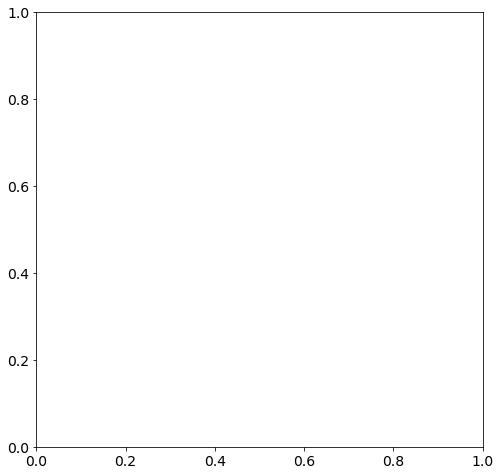

In [30]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)


plt.figure(figsize=(8,8))
upper_limit = 700
lower_limit = -40
plt.plot([lower_limit,upper_limit],
         [lower_limit,upper_limit],"--",c="k", label="1:1", zorder =1)
plt.plot( test.reference,test.image, ".", label="Individual Extraction")
# plt.plot(group_test.reference, group_test.image, ".", label="Measurement median")
plt.errorbar(group_test.reference, group_test.image, yerr=0.25*group_test.image,
             fmt=".",color="C3",ecolor="C1", label="Measurement Median", zorder=10)




plt.xlim([lower_limit,upper_limit])
plt.ylim([lower_limit,upper_limit])

plt.xlabel("Reference [Jy]")
plt.ylabel("Image [Jy]")
plt.legend()

mu: 1.00218437936 sigma: 0.321824048878


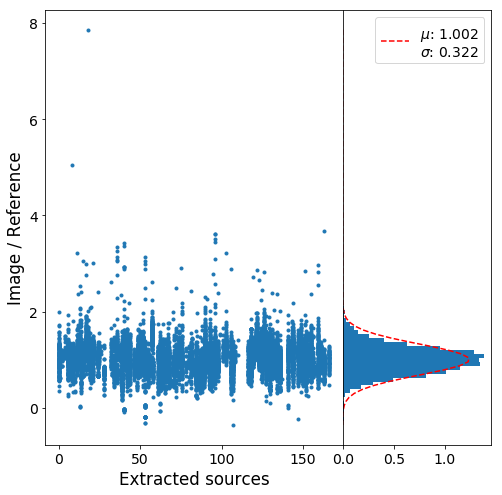

In [83]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(8,8))
gs1 = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gs1.update(wspace=0.0, hspace=0.0)



# plt.subplot(121)
plt.subplot(gs1[0])
plt.plot( test.image/test.reference, ".", label="Individual Extraction")
plt.ylabel("Image / Reference")
plt.xlabel("Extracted sources")
(mu, sigma) = norm.fit(test.image/test.reference)
#     n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
#                                    bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")


# plt.subplot(122)
plt.subplot(gs1[1])
n, bins, patches   =  plt.hist(test.image/test.reference, bins=100, normed=1, orientation="horizontal")
y = mlab.normpdf( bins, mu, sigma)
plt.plot(y,bins,"--", c="red", label=r"$\mu$"": {}\n"r"$\sigma$"": {}".format(round(mu,3),round(sigma,3)))
plt.legend()
plt.yticks([])


# plt.xlim([-0.5,4])
print "mu:", mu,"sigma:", sigma
# plt.tight_layout()

mu: 1.00218437936 sigma: 0.321824048878


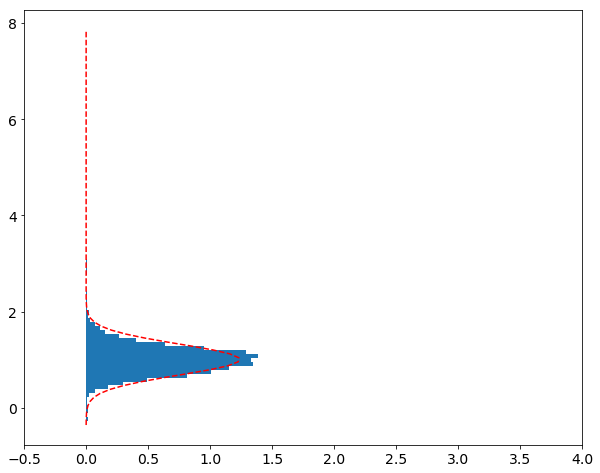

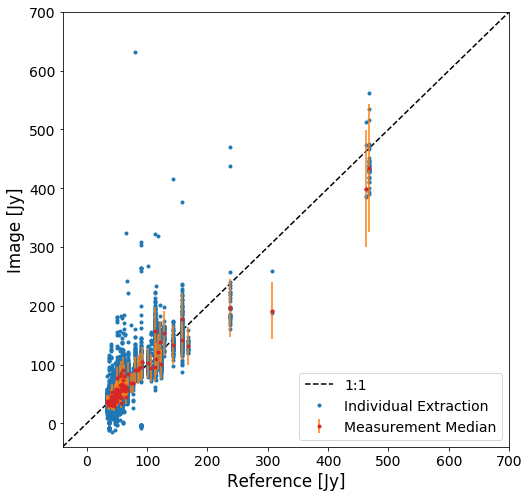

In [62]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }
matplotlib.rc('font', **font)


plt.figure(figsize=(8,8))
upper_limit = 700
lower_limit = -40
plt.plot([lower_limit,upper_limit],
         [lower_limit,upper_limit],"--",c="k", label="1:1", zorder =1)
plt.plot( test.reference, test.image, ".", label="Individual Extraction")
# plt.plot(group_test.reference, group_test.image, ".", label="Measurement median")
plt.errorbar(group_test.reference, group_test.image, yerr=0.25*group_test.image,
             fmt=".",color="C3",ecolor="C1", label="Measurement Median", zorder=10)




plt.xlim([lower_limit,upper_limit])
plt.ylim([lower_limit,upper_limit])

plt.xlabel("Reference [Jy]")
plt.ylabel("Image [Jy]")
plt.legend()

In [ ]:
test.groupby(test.index).std().image.values)/np.array(test.groupby(test.index).median().image

Mean flux density uncertainty from individual image,  25.31 %


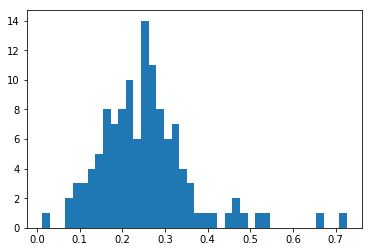

In [55]:
A = np.array(test.groupby(test.index).std().image.values)/np.array(test.groupby(test.index).median().image)
histout = plt.hist(A[~np.isnan(A)], bins=40)
print "Mean flux density uncertainty from individual image, ", round(np.mean(A[~np.isnan(A)])*100.,2), "%"

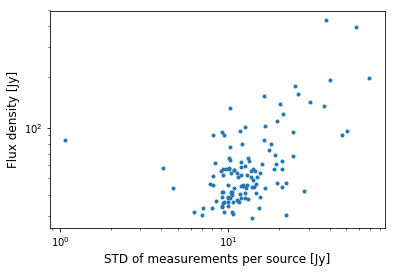

In [54]:
plt.plot(test.groupby(test.index).std().image.values,
         test.groupby(test.index).median().image, ".")

plt.ylabel("Flux density [Jy]")
plt.xlabel("STD of measurements per source [Jy]")
plt.xscale("log")
plt.yscale("log")

### Image, on/off

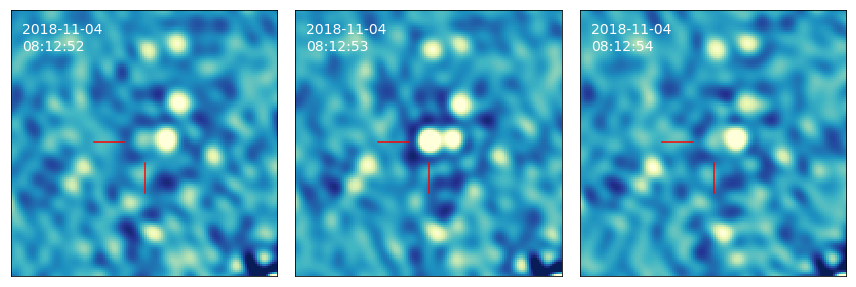

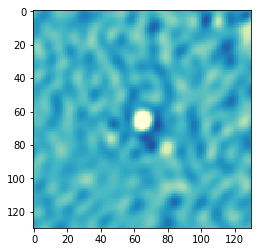

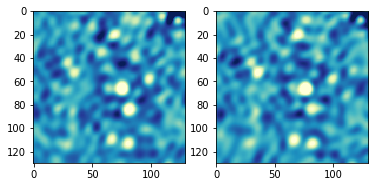

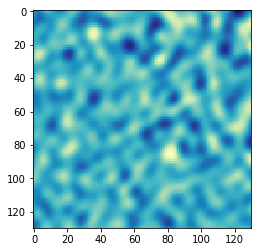

In [90]:
pos = [727,186]
delta =130


plt.figure(figsize=(12,4))
filename1 = "/data/ASf_20181104/2018-11-04T08:12:52-S298.6-B8.fits"
plt.subplot(131)
plt.imshow(fits.open(filename1)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-50,vmax=50, cmap="YlGnBu_r", origin="lower")

plt.xticks([])
plt.yticks([])
plt.text(5.0,110.0,"2018-11-04 \n08:12:52", color="white", fontsize=14)
plt.plot([65,65],[55,40], "r")
plt.plot([55,40],[65,65], "r")


filename2 = "/data/ASf_20181104/2018-11-04T08:12:53-S298.6-B8.fits"
plt.subplot(132)
plt.imshow(fits.open(filename2)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-50,vmax=50, cmap="YlGnBu_r", origin="lower")

plt.xticks([])
plt.yticks([])
plt.text(5.0,110.0,"2018-11-04 \n08:12:53", color="white", fontsize=14)
plt.plot([65,65],[55,40], "r")
plt.plot([55,40],[65,65], "r")

filename3 = "/data/ASf_20181104/2018-11-04T08:12:54-S298.6-B8.fits"
plt.subplot(133)
plt.imshow(fits.open(filename3)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-50,vmax=50, cmap="YlGnBu_r", origin="lower")
plt.text(5.0,110.0,"2018-11-04 \n08:12:54", color="white", fontsize=14)

plt.plot([65,65],[55,40], "r")
plt.plot([55,40],[65,65], "r")

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("/home/kuiack/PSR_onoff_img.png")








plt.figure()
plt.imshow(fits.open(filename2)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2] -\
           fits.open(filename3)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-50,vmax=50, cmap="YlGnBu_r")

plt.figure()
filename1 = "/data/ASf_20181104/2018-11-04T08:12:52-S298.6-B8.fits"
plt.subplot(121)
plt.imshow(fits.open(filename1)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-40,vmax=40, cmap="YlGnBu_r")

filename2 = "/data/ASf_20181104/2018-11-04T08:12:54-S298.6-B8.fits"
plt.subplot(122)
plt.imshow(fits.open(filename2)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-40,vmax=40, cmap="YlGnBu_r")


plt.figure()
plt.imshow(fits.open(filename1)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2] - fits.open(filename2)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2],
           vmin=-30,vmax=30, cmap="YlGnBu_r")

## PSR observation time

In [9]:
obs_result = pd.read_csv("/home/kuiack/PSR_observations.csv")
obs_result[obs_result.trap == 0].sort_values("obs_count", ascending=False)

Unnamed: 0  obs_count                                           obs_list  \
64           64      12119  /mnt/nex0/data/vis_archive/201803261842/300-20...   
107         107      11829  /mnt/nex1/data/vis_archive/201804301510/300-20...   
39           39      11251  /mnt/nex0/data/vis_archive/201804281040/300-20...   
223         224      10807                   /mnt/ais003/300-201812160230.cal   
144         144      10807  /mnt/nex1/data/vis_archive/201812160230/300-20...   
31           31       9899  /mnt/nex0/data/vis_archive/201901/300-20190127...   
224         225       9533                   /mnt/ais003/300-201902232216.cal   
175         175       9458  /mnt/nex1/data/vis_archive/201804261245/300-20...   
99           99       9341  /mnt/nex2/data/vis_archive/201803272014/300-20...   
257         258       9297                   /mnt/ais003/300-201902242216.cal   
5             5       8928  /mnt/nex0/data/vis_archive/201806291215/300-20...   
228         229       8891                   /mnt/ais003/300-201901300005.cal   
36           36       8891  /mnt/nex0/data/vis_archive/201901/300-20190130...   
227         228       8719                   /mnt/ais003/300-201902010000.cal   
221         222       8042                   /mnt/ais003/300-201902262216.cal   
55           55       7668  /mnt/nex0/data/vis_archive/201807071401/300-20...   
267         268       6948                   /mnt/ais003/300-201902080002.cal   
214         215       6747                   /mnt/ais003/300-201902030025.cal   
71           71       6638  /mnt/nex2/data/vis_archive/201705311300/300-20...   
182         182       6476  /mnt/nex1/data/vis_archive/201804241908/300-20...   
265         266       6067                   /mnt/ais003/300-201903041640.cal   
77           77       5993  /mnt/nex2/data/vis_archive/201811/300-20181128...   
17           17       5533  /mnt/nex0/data/vis_archive/201705311701/300-20...   
169         169       5442  /mnt/nex1/data/vis_archive/201804241407/300-20...   
193         193       5336  /mnt/nex1/data/vis_archive/201804271732/300-20...   
188         188       5270  /mnt/nex1/data/vis_archive/201804271920/300-20...   
216         217       5026                   /mnt/ais003/300-201809280900.cal   
41           41       4984  /mnt/nex0/data/vis_archive/201805251545/300-20...   
46           46       4972  /mnt/nex0/data/vis_archive/201805261730/300-20...   
173         173       4894  /mnt/nex1/data/vis_archive/201804081700/300-20...   
..          ...        ...                                                ...   
177         177          0  /mnt/nex1/data/vis_archive/201804280745/300-20...   
152         152          0  /mnt/nex1/data/vis_archive/201702281405/300-20...   
180         180          0  /mnt/nex1/data/vis_archive/201804120220/300-20...   
181         181          0  /mnt/nex1/data/vis_archive/201804240910/300-20...   
183         183          0  /mnt/nex1/data/vis_archive/201805010100/300-20...   
184         184          0  /mnt/nex1/data/vis_archive/201803300948/300-20...   
185         185          0  /mnt/nex1/data/vis_archive/201803250005/300-20...   
187         187          0  /mnt/nex1/data/vis_archive/201803220405/300-20...   
190         190          0  /mnt/nex1/data/vis_archive/201804180330/300-20...   
158         158          0  /mnt/nex1/data/vis_archive/201803201430/300-20...   
149         149          0  /mnt/nex1/data/vis_archive/201812161645/300-20...   
78           78          0  /mnt/nex2/data/vis_archive/201811/300-20181129...   
109         109          0  /mnt/nex1/data/vis_archive/201803262300/300-20...   
97           97          0  /mnt/nex2/data/vis_archive/201702281203/300-20...   
98           98          0  /mnt/nex2/data/vis_archive/201702270116/300-20...   
100         100          0  /mnt/nex2/data/vis_archive/201803300440/300-20...   
101         101          0  /mnt/nex2/data/vis_archive/201804140330/300-20...   
105         105          0  /mnt/nex

## TraP monitor list

In [13]:
import json


monitor_coords = [[148.48,7.6],
                  [149.21,9.29],
                  [150.31,7.46],
                  [149.92,5.47],
                  [150.31,7.46],
                  [148.40,5.43],
                  [147.18,7.09],
                  [150.31,7.46],
                  [151.38,8.39],
                  [150.31,7.46],
                  [152.14,7.26],
                  [148.69,10.92],
                  [146.08,9.47],
                 ]

for i in range(len(aart)):
    monitor_coords.append([aart["ra"].values[i],
                           aart["decl"].values[i]])

with open('/home/kuiack/PRS_monitor.json','w') as outfile:
    json.dump(monitor_coords,outfile)

In [14]:
monitor_coords

[[148.48, 7.6],
 [149.21, 9.29],
 [150.31, 7.46],
 [149.92, 5.47],
 [150.31, 7.46],
 [148.4, 5.43],
 [147.18, 7.09],
 [150.31, 7.46],
 [151.38, 8.39],
 [150.31, 7.46],
 [152.14, 7.26],
 [148.69, 10.92],
 [146.08, 9.47],
 [176.84, 49.649999999999999],
 [50.289999999999999, 41.689999999999998],
 [52.43, 55.380000000000003],
 [45.649999999999999, 50.869999999999997],
 [35.090000000000003, 62.539999999999999],
 [36.130000000000003, 43.060000000000002],
 [129.99000000000001, 65.170000000000002],
 [67.219999999999999, 76.939999999999998],
 [133.77000000000001, 13.9],
 [106.84999999999999, 63.32],
 [101.69, 21.350000000000001],
 [104.47, 54.229999999999997],
 [158.84, 58.189999999999998],
 [176.75, 31.539999999999999],
 [108.06, 74.829999999999998],
 [194.97, 27.82],
 [69.670000000000002, 29.75],
 [168.93000000000001, 40.579999999999998],
 [176.59999999999999, 19.59],
 [130.38999999999999, 57.890000000000001],
 [117.73999999999999, 55.840000000000003],
 [148.11000000000001, 73.180000000000007

In [7]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


In [10]:
aart.decl

0      49.65
1      41.69
2      55.38
3      50.87
4      62.54
5      43.06
6      65.17
7      76.94
8      13.90
9      63.32
10     21.35
11     54.23
12     58.19
13     31.54
14     74.83
15     27.82
16     29.75
17     40.58
18     19.59
19     57.89
20     55.84
21     73.18
22     32.69
23     23.96
24     37.79
25     25.97
26     44.30
27     40.15
28     24.61
29     40.37
       ...  
137    59.37
138    17.19
139     6.23
140    60.88
141    21.23
142     7.66
143    34.13
144    64.36
145    48.74
146     7.01
147    54.38
148    29.73
149    46.34
150    61.48
151    34.78
152    12.74
153    53.46
154    45.56
155    43.62
156    27.40
157    38.14
158    11.21
159    33.62
160    63.13
161    31.54
162     5.70
163    24.14
164    28.16
165    32.88
166    82.32
Name: decl, Length: 167, dtype: float64